# Assignment 2: The Winter is here
##### This works best with epic battle music. Spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
from PIL import Image, ImageFont, ImageDraw
import glob
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from random import randint

resnet_input = 224 #size of resnet18 input images, Took it from resnet paper implementation
use_gpu = False
iou_threshold = 0.3
stride = 5

In [2]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 100
num_epochs = 5
learning_rate =  0.01
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [5]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [108]:
def jamie_bronn_build_dataset(root, image, image_arr, class_arr, orig_image,train):
    # Begin
    filename = root.find('filename').text
    bboxarr = []
    #Loop on every object of the loop
    for objects in root.findall('object'):
        class_name = objects.find('name').text
        box_position = [int(objects.find('bndbox').find('xmin').text), \
                        int(objects.find('bndbox').find('ymin').text), \
                        int(objects.find('bndbox').find('xmax').text), \
                        int(objects.find('bndbox').find('ymax').text)]
        bboxarr.append(box_position)
        img = image.crop(box_position)
        print("In image "+filename+" found "+class_name)
        image_arr.append(img.convert('RGB'))  
        # every class name corresponds to some number in the classes array that we add to the class_name array
        class_arr.append(classes.index(class_name))
        orig_image.append(filename)
    if train:
        # Now generating background images for the given image file for training only.
        num = 0
        while(num < 1):
            bbox = image.getbbox()
            boxA = random_bbox(bbox)
            mscore = 0
            for boxB in bboxarr:
                score = (bb_intersection_over_union(boxA, boxB))
                if (score>mscore):
                    mscore = score
            if (mscore < iou_threshold):
                image_arr.append(img.crop(boxA).convert('RGB'))
                class_arr.append(classes.index('__background__'))
                orig_image.append(filename)
                num = num + 1        

In [109]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.image_arr  = []
        self.class_arr  = []
        self.orig_image = []
        self.transform = transform

        if(train):
            dir = root_dir + 'train/VOCdevkit/VOC2007/'
        else :
            dir = root_dir + 'test/VOCdevkit/VOC2007/'
        
        anotdir = dir + 'Annotations/'
        imdir   = dir + 'JPEGImages/'
        
        for filepath in glob.glob(anotdir+'*.xml'):
            tree = ET.parse(filepath)
            root = tree.getroot()
            filename = root.find('filename').text
            image = Image.open(imdir+filename)
            jamie_bronn_build_dataset(root, image, self.image_arr, self.class_arr, self.orig_image, train)

    def __len__(self):
        # Begin
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.image_arr)
        
    def __getitem__(self, idx):
        # Begin
        if self.transform is None:
            return (self.image_arr[idx], self.class_arr[idx], self.orig_image[idx])
        else:
            img_transformed = self.transform(self.image_arr[idx])
            return (img_transformed, self.class_arr[idx], self.orig_image[idx])
    

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [110]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='/home/eeshangd/vision_env/LELImproved/dataset/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = hound_dataset(root_dir='/home/eeshangd/vision_env/LELImproved/dataset/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In image 005906.jpg found bus
In image 005906.jpg found person
In image 005906.jpg found person
In image 006141.jpg found bottle
In image 007219.jpg found tvmonitor
In image 007219.jpg found chair
In image 003260.jpg found tvmonitor
In image 003260.jpg found person
In image 003260.jpg found person
In image 003260.jpg found person
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found diningtable
In image 004438.jpg found dog
In image 004438.jpg found person
In image 004438.jpg found person
In image 004438.jpg found tvmonitor
In image 001125.jpg found car
In image 001125.jpg found car
In image 001125.jpg found car
In image 001125.jpg found person
In image 001125.jpg found person
In image 006802.jpg found train
In image 006802.jpg found person
In image 006802.jpg found person
In image 003254.jpg found bird
In image 007187.jpg found sofa
In image 007187.jpg found person
In image 007187.jpg f

In image 007901.jpg found person
In image 007901.jpg found person
In image 007901.jpg found person
In image 007901.jpg found person
In image 007901.jpg found person
In image 005124.jpg found cow
In image 005124.jpg found person
In image 001014.jpg found dog
In image 001014.jpg found dog
In image 001014.jpg found person
In image 001014.jpg found chair
In image 002311.jpg found car
In image 002311.jpg found car
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 002311.jpg found person
In image 003905.jpg found bird
In image 002621.jpg found bi

In image 006139.jpg found dog
In image 006139.jpg found dog
In image 000381.jpg found diningtable
In image 000381.jpg found chair
In image 000381.jpg found chair
In image 000381.jpg found chair
In image 000381.jpg found bottle
In image 004785.jpg found diningtable
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 002261.jpg found horse
In image 002261.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 005450.jpg found person
In image 007498.jpg found diningtable
In image 007498.jpg found person
In image 000122.jpg found cat
In image 002378.jpg

In image 005695.jpg found person
In image 005695.jpg found person
In image 006218.jpg found bus
In image 006218.jpg found car
In image 009414.jpg found sofa
In image 009414.jpg found person
In image 009414.jpg found person
In image 009414.jpg found person
In image 007999.jpg found sofa
In image 007999.jpg found pottedplant
In image 007999.jpg found pottedplant
In image 007999.jpg found tvmonitor
In image 007074.jpg found bus
In image 007074.jpg found car
In image 007074.jpg found car
In image 007555.jpg found train
In image 003998.jpg found car
In image 003740.jpg found person
In image 003740.jpg found person
In image 003740.jpg found person
In image 003740.jpg found dog
In image 007222.jpg found train
In image 007222.jpg found train
In image 007222.jpg found train
In image 008813.jpg found bird
In image 008813.jpg found person
In image 008813.jpg found person
In image 008813.jpg found person
In image 008813.jpg found person
In image 008813.jpg found person
In image 008813.jpg found pe

In image 001945.jpg found person
In image 001945.jpg found horse
In image 008655.jpg found pottedplant
In image 008655.jpg found dog
In image 008655.jpg found dog
In image 008655.jpg found tvmonitor
In image 008655.jpg found diningtable
In image 008655.jpg found chair
In image 008655.jpg found chair
In image 008655.jpg found chair
In image 008655.jpg found chair
In image 009230.jpg found person
In image 009230.jpg found motorbike
In image 000860.jpg found car
In image 000860.jpg found person
In image 000860.jpg found person
In image 006120.jpg found motorbike
In image 006120.jpg found car
In image 004095.jpg found dog
In image 002906.jpg found train
In image 003243.jpg found car
In image 003243.jpg found car
In image 007786.jpg found cow
In image 007786.jpg found cow
In image 007786.jpg found cow
In image 007786.jpg found person
In image 002249.jpg found horse
In image 007182.jpg found person
In image 007182.jpg found person
In image 003110.jpg found dog
In image 003110.jpg found dog
I

In image 009527.jpg found boat
In image 009527.jpg found boat
In image 009527.jpg found boat
In image 003204.jpg found tvmonitor
In image 006735.jpg found dog
In image 006735.jpg found person
In image 006735.jpg found person
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found bottle
In image 009726.jpg found bottle
In image 009726.jpg found diningtable
In image 009726.jpg found diningtable
In image 009726.jpg found person
In image 005796.jpg found person
In image 005796.jpg found tvmonitor
In image 003681.jpg found sheep
In image 003681.jpg found sheep
In image 003681.jpg found sheep
In image 003681.jpg found dog
In image 003681.jpg found dog
In image 003681.jpg found dog
In image 003681.jpg found dog
In image 003681.jpg found sheep
In image 007138.jpg found person
In image 007138.jpg found horse
In image 003895.jpg found train
In image 002585.jpg found person
In image 002585.jpg found person
In image 002585.jpg f

In image 007697.jpg found horse
In image 007697.jpg found person
In image 006301.jpg found car
In image 000923.jpg found tvmonitor
In image 000923.jpg found sofa
In image 000923.jpg found pottedplant
In image 000923.jpg found pottedplant
In image 000923.jpg found tvmonitor
In image 000923.jpg found pottedplant
In image 009295.jpg found person
In image 009295.jpg found bicycle
In image 009295.jpg found tvmonitor
In image 004508.jpg found bottle
In image 004508.jpg found bottle
In image 004508.jpg found bottle
In image 004508.jpg found person
In image 004508.jpg found person
In image 005315.jpg found bicycle
In image 005315.jpg found person
In image 007621.jpg found sheep
In image 007621.jpg found sheep
In image 009272.jpg found aeroplane
In image 002502.jpg found train
In image 007376.jpg found bus
In image 007376.jpg found bus
In image 007376.jpg found car
In image 006088.jpg found chair
In image 006088.jpg found chair
In image 006088.jpg found sofa
In image 006088.jpg found sofa
In im

In image 005995.jpg found train
In image 005995.jpg found train
In image 003957.jpg found train
In image 003061.jpg found chair
In image 003061.jpg found chair
In image 003061.jpg found chair
In image 003749.jpg found person
In image 002554.jpg found person
In image 002554.jpg found horse
In image 001082.jpg found cat
In image 001082.jpg found pottedplant
In image 007709.jpg found person
In image 007709.jpg found person
In image 007709.jpg found bicycle
In image 007709.jpg found car
In image 007709.jpg found car
In image 007709.jpg found car
In image 007709.jpg found car
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found 

In image 007579.jpg found person
In image 007579.jpg found person
In image 007579.jpg found person
In image 007579.jpg found person
In image 007579.jpg found person
In image 000420.jpg found car
In image 004498.jpg found boat
In image 009832.jpg found bus
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 004527.jpg found sheep
In image 002962.jpg found tvmonitor
In image 002962.jpg found person
In image 002962.jpg found person
In image 002682.jpg found car
In i

In image 007274.jpg found aeroplane
In image 002912.jpg found bicycle
In image 002912.jpg found person
In image 005527.jpg found person
In image 009087.jpg found pottedplant
In image 009087.jpg found pottedplant
In image 009087.jpg found pottedplant
In image 009087.jpg found person
In image 009087.jpg found person
In image 009087.jpg found person
In image 009087.jpg found cat
In image 009087.jpg found chair
In image 008415.jpg found dog
In image 008415.jpg found dog
In image 005705.jpg found boat
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found car
In image 000480.jpg found person
In image 000480.jpg found person
In image 000480.jpg found person
In image 000480.jpg found aeroplane
In image 001970.jpg found bottle
In image 006626.jpg found diningtable
In image 006626.jpg found person
In image 006626.jpg found perso

In image 001766.jpg found person
In image 001766.jpg found person
In image 001766.jpg found person
In image 001766.jpg found person
In image 001766.jpg found person
In image 001766.jpg found person
In image 001766.jpg found horse
In image 001766.jpg found horse
In image 001766.jpg found horse
In image 001766.jpg found horse
In image 004496.jpg found chair
In image 004496.jpg found chair
In image 004496.jpg found person
In image 004496.jpg found person
In image 004496.jpg found person
In image 004269.jpg found person
In image 004269.jpg found person
In image 000814.jpg found person
In image 000814.jpg found person
In image 008728.jpg found dog
In image 008728.jpg found person
In image 008728.jpg found chair
In image 005526.jpg found tvmonitor
In image 005526.jpg found person
In image 005526.jpg found person
In image 007167.jpg found car
In image 007167.jpg found car
In image 007167.jpg found person
In image 007167.jpg found person
In image 004816.jpg found dog
In image 003331.jpg found 

In image 009446.jpg found tvmonitor
In image 005914.jpg found boat
In image 005914.jpg found boat
In image 005914.jpg found boat
In image 008562.jpg found bus
In image 008562.jpg found car
In image 008562.jpg found car
In image 008562.jpg found motorbike
In image 008562.jpg found person
In image 008562.jpg found person
In image 008562.jpg found person
In image 008562.jpg found motorbike
In image 008837.jpg found tvmonitor
In image 008837.jpg found tvmonitor
In image 006643.jpg found bird
In image 005895.jpg found aeroplane
In image 007974.jpg found cat
In image 004295.jpg found car
In image 006876.jpg found chair
In image 006876.jpg found person
In image 006876.jpg found cat
In image 003760.jpg found motorbike
In image 003760.jpg found motorbike
In image 003760.jpg found person
In image 003760.jpg found person
In image 003760.jpg found person
In image 003760.jpg found person
In image 003760.jpg found person
In image 003760.jpg found person
In image 003760.jpg found person
In image 0037

In image 005310.jpg found person
In image 005310.jpg found person
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 000588.jpg found sheep
In image 008423.jpg found bird
In image 004300.jpg found motorbike
In image 008222.jpg found dog
In image 008224.jpg found person
In image 008224.jpg found person
In image 008224.jpg found person
In image 008224.jpg found person
In image 008224.jpg found person
In image 008224.jpg found person
In image 008224.jpg found person
In image 001936.jpg found aeroplane
In image 001936.jpg found aeroplane
In image 001936.jpg found aeroplane
In image 001971.jpg found cat
In image 001971.jpg found chair
In image 002668.jpg found diningtable
In image 002668.jpg found person
In image 002668.jpg found person
In image 002668.jpg found person
In image 002668.jpg found person
In image 002668.jpg found pottedplant
In i

In image 002757.jpg found train
In image 000868.jpg found sofa
In image 000868.jpg found pottedplant
In image 008029.jpg found pottedplant
In image 008121.jpg found tvmonitor
In image 008450.jpg found aeroplane
In image 002373.jpg found car
In image 002373.jpg found car
In image 002956.jpg found bicycle
In image 006777.jpg found pottedplant
In image 006777.jpg found person
In image 006777.jpg found person
In image 002333.jpg found bird
In image 002333.jpg found bird
In image 002333.jpg found bird
In image 002333.jpg found bird
In image 002333.jpg found bird
In image 000110.jpg found person
In image 000110.jpg found person
In image 000110.jpg found person
In image 008346.jpg found dog
In image 008413.jpg found person
In image 008413.jpg found person
In image 008413.jpg found chair
In image 008413.jpg found chair
In image 008332.jpg found person
In image 008332.jpg found dog
In image 007421.jpg found bird
In image 008586.jpg found car
In image 002615.jpg found sheep
In image 002615.jpg f

In image 000200.jpg found person
In image 000200.jpg found person
In image 000200.jpg found person
In image 000200.jpg found person
In image 000200.jpg found bottle
In image 000200.jpg found bottle
In image 004370.jpg found bottle
In image 004370.jpg found person
In image 004370.jpg found person
In image 001012.jpg found aeroplane
In image 001922.jpg found aeroplane
In image 000072.jpg found motorbike
In image 000072.jpg found motorbike
In image 005131.jpg found cat
In image 004849.jpg found train
In image 002347.jpg found pottedplant
In image 002347.jpg found pottedplant
In image 002347.jpg found pottedplant
In image 000826.jpg found boat
In image 009454.jpg found chair
In image 009454.jpg found tvmonitor
In image 004145.jpg found motorbike
In image 004145.jpg found motorbike
In image 004145.jpg found motorbike
In image 004145.jpg found motorbike
In image 004145.jpg found car
In image 004145.jpg found motorbike
In image 004145.jpg found car
In image 004145.jpg found person
In image 00

In image 008252.jpg found aeroplane
In image 008506.jpg found train
In image 008506.jpg found train
In image 003673.jpg found dog
In image 003673.jpg found dog
In image 006438.jpg found car
In image 006438.jpg found car
In image 002717.jpg found bird
In image 003605.jpg found train
In image 008633.jpg found bicycle
In image 008633.jpg found bicycle
In image 008633.jpg found car
In image 008633.jpg found car
In image 007266.jpg found chair
In image 007266.jpg found person
In image 007266.jpg found person
In image 007266.jpg found chair
In image 007266.jpg found diningtable
In image 003169.jpg found cat
In image 003169.jpg found sofa
In image 004244.jpg found car
In image 004244.jpg found car
In image 004244.jpg found car
In image 004244.jpg found person
In image 004244.jpg found person
In image 004244.jpg found person
In image 002443.jpg found dog
In image 002443.jpg found person
In image 003417.jpg found train
In image 003417.jpg found person
In image 003417.jpg found person
In image 0

In image 009908.jpg found cow
In image 009908.jpg found cow
In image 009908.jpg found bird
In image 009908.jpg found bird
In image 009908.jpg found bird
In image 009778.jpg found train
In image 008203.jpg found sofa
In image 008203.jpg found sofa
In image 001053.jpg found dog
In image 008087.jpg found car
In image 003550.jpg found person
In image 003550.jpg found person
In image 004012.jpg found person
In image 004012.jpg found person
In image 004012.jpg found chair
In image 008311.jpg found horse
In image 006687.jpg found bottle
In image 007311.jpg found chair
In image 007311.jpg found chair
In image 007311.jpg found chair
In image 004446.jpg found cat
In image 004446.jpg found pottedplant
In image 006747.jpg found motorbike
In image 009923.jpg found cat
In image 008513.jpg found person
In image 001662.jpg found car
In image 002666.jpg found motorbike
In image 002666.jpg found car
In image 004379.jpg found aeroplane
In image 003444.jpg found sofa
In image 006045.jpg found chair
In ima

In image 008171.jpg found diningtable
In image 008171.jpg found pottedplant
In image 008171.jpg found pottedplant
In image 008171.jpg found person
In image 004826.jpg found cow
In image 004826.jpg found person
In image 004826.jpg found person
In image 008477.jpg found dog
In image 008477.jpg found dog
In image 007489.jpg found dog
In image 006177.jpg found motorbike
In image 006177.jpg found person
In image 006177.jpg found cow
In image 006177.jpg found cow
In image 001607.jpg found dog
In image 001304.jpg found person
In image 001304.jpg found bicycle
In image 004075.jpg found bottle
In image 004075.jpg found person
In image 004075.jpg found person
In image 007297.jpg found aeroplane
In image 003979.jpg found bird
In image 003979.jpg found bird
In image 003979.jpg found bird
In image 006230.jpg found dog
In image 008933.jpg found cat
In image 008933.jpg found pottedplant
In image 008933.jpg found pottedplant
In image 005577.jpg found car
In image 004372.jpg found horse
In image 004372

In image 001239.jpg found dog
In image 001239.jpg found dog
In image 001239.jpg found dog
In image 006260.jpg found cat
In image 008838.jpg found bus
In image 008838.jpg found car
In image 008838.jpg found person
In image 007285.jpg found car
In image 009114.jpg found horse
In image 009114.jpg found person
In image 009711.jpg found car
In image 009711.jpg found car
In image 009711.jpg found car
In image 009711.jpg found car
In image 009711.jpg found person
In image 009711.jpg found person
In image 007865.jpg found pottedplant
In image 007865.jpg found pottedplant
In image 007865.jpg found chair
In image 007865.jpg found chair
In image 007865.jpg found chair
In image 000598.jpg found tvmonitor
In image 000598.jpg found chair
In image 000598.jpg found tvmonitor
In image 004939.jpg found pottedplant
In image 004939.jpg found chair
In image 004939.jpg found person
In image 001312.jpg found cow
In image 009365.jpg found aeroplane
In image 005601.jpg found dog
In image 005601.jpg found dog
I

In image 005535.jpg found dog
In image 007859.jpg found sheep
In image 008557.jpg found tvmonitor
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found sofa
In image 007538.jpg found chair
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006427.jpg found person
In image 006427.jpg found person
In image 006427.jpg found person
In image 006530.jpg found chair
In image 006530.jpg found sofa
In image 006530.jpg found chair
In image 006530.

In image 000328.jpg found person
In image 003416.jpg found bird
In image 003416.jpg found bird
In image 003416.jpg found bird
In image 003416.jpg found bird
In image 003416.jpg found bird
In image 003416.jpg found bird
In image 003416.jpg found person
In image 000753.jpg found diningtable
In image 000753.jpg found bottle
In image 000753.jpg found bottle
In image 000753.jpg found bottle
In image 000753.jpg found person
In image 000753.jpg found person
In image 000753.jpg found person
In image 000753.jpg found person
In image 000753.jpg found person
In image 008140.jpg found pottedplant
In image 008140.jpg found pottedplant
In image 008140.jpg found pottedplant
In image 002545.jpg found person
In image 002545.jpg found bottle
In image 002545.jpg found sofa
In image 002545.jpg found sofa
In image 003039.jpg found person
In image 003039.jpg found person
In image 001015.jpg found bird
In image 001015.jpg found bird
In image 001015.jpg found bird
In image 003436.jpg found horse
In image 0034

In image 009808.jpg found horse
In image 003244.jpg found train
In image 000667.jpg found horse
In image 000667.jpg found horse
In image 001441.jpg found chair
In image 001441.jpg found chair
In image 001441.jpg found chair
In image 001441.jpg found chair
In image 001441.jpg found chair
In image 001441.jpg found chair
In image 001441.jpg found diningtable
In image 006833.jpg found sheep
In image 006833.jpg found person
In image 000174.jpg found person
In image 007177.jpg found diningtable
In image 007177.jpg found bottle
In image 007177.jpg found chair
In image 004500.jpg found cow
In image 004500.jpg found cow
In image 009331.jpg found horse
In image 009331.jpg found person
In image 009331.jpg found dog
In image 009331.jpg found dog
In image 009331.jpg found dog
In image 003443.jpg found dog
In image 002042.jpg found horse
In image 007899.jpg found bottle
In image 008951.jpg found dog
In image 009886.jpg found cat
In image 009920.jpg found car
In image 009920.jpg found car
In image 00

In image 005599.jpg found bicycle
In image 005599.jpg found bicycle
In image 005599.jpg found person
In image 005599.jpg found person
In image 008268.jpg found car
In image 008268.jpg found car
In image 008268.jpg found car
In image 002609.jpg found dog
In image 007072.jpg found cow
In image 008173.jpg found train
In image 007517.jpg found cat
In image 007606.jpg found person
In image 002152.jpg found cow
In image 004879.jpg found bicycle
In image 004879.jpg found person
In image 004879.jpg found person
In image 007655.jpg found bicycle
In image 001673.jpg found cat
In image 001673.jpg found bottle
In image 008927.jpg found cow
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 008670.jpg found bird
In image 008670.jpg found bird
In image 007533.jpg found boat
In image 007533.jpg found boat
In image 009656.jpg found bicycle
In image 009656.jpg found person
In image

In image 008702.jpg found bus
In image 008702.jpg found bicycle
In image 008702.jpg found person
In image 008702.jpg found person
In image 008702.jpg found person
In image 009351.jpg found aeroplane
In image 002012.jpg found person
In image 002012.jpg found person
In image 007657.jpg found person
In image 005511.jpg found horse
In image 005511.jpg found person
In image 007886.jpg found bird
In image 006657.jpg found cat
In image 008409.jpg found tvmonitor
In image 008409.jpg found sofa
In image 002024.jpg found bus
In image 002024.jpg found bus
In image 002024.jpg found bus
In image 002024.jpg found person
In image 004318.jpg found dog
In image 009926.jpg found person
In image 009926.jpg found person
In image 009926.jpg found bicycle
In image 009926.jpg found bicycle
In image 003921.jpg found dog
In image 009738.jpg found person
In image 006448.jpg found bottle
In image 006448.jpg found bottle
In image 009224.jpg found person
In image 009224.jpg found person
In image 009224.jpg found p

In image 004686.jpg found person
In image 004686.jpg found person
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 004686.jpg found cow
In image 006765.jpg found chair
In image 006765.jpg found pottedplant
In image 006765.jpg found pottedplant
In image 006765.jpg found pottedplant
In image 006765.jpg found pottedplant
In image 008701.jpg found person
In image 008701.jpg found person
In image 008701.jpg found sofa
In image 006424.jpg found sofa
In image 006424.jpg found chair
In image 002537.jpg found dog
In image 001499.jpg found person
In image 001499.jpg found person
In image 001499.jpg found person
In image 009713.jpg found dog
In image 009713.jpg found person
In image 009713.jpg found person
In im

In image 003814.jpg found cat
In image 005056.jpg found dog
In image 007121.jpg found bottle
In image 007121.jpg found person
In image 007121.jpg found person
In image 007003.jpg found bus
In image 007003.jpg found car
In image 007003.jpg found car
In image 007003.jpg found car
In image 007003.jpg found car
In image 006252.jpg found dog
In image 001240.jpg found person
In image 001240.jpg found person
In image 001240.jpg found person
In image 005614.jpg found boat
In image 005614.jpg found boat
In image 005614.jpg found boat
In image 000680.jpg found bird
In image 006698.jpg found person
In image 006698.jpg found person
In image 004327.jpg found dog
In image 004327.jpg found person
In image 004327.jpg found person
In image 005509.jpg found aeroplane
In image 005509.jpg found person
In image 005509.jpg found person
In image 005509.jpg found person
In image 005509.jpg found person
In image 005509.jpg found person
In image 005509.jpg found person
In image 005509.jpg found person
In image 

In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 009086.jpg found train
In image 004828.jpg found person
In image 004828.jpg found person
In image 004828.jpg found person
In image 004828.jpg found car
In image 004828.jpg found car
In image 004828.jpg found car
In image 007224.jpg found train
In image 007089.jpg found dog
In image 006084.jpg found cat
In image 000041.jpg found tvmonitor
In image 000041.jpg found person
In image 000041.jpg found person
In image 000211.jpg found cow
In image 000236.jpg found bird
In image 002680.jpg found dog
In image 009491.jpg found sofa
In image 009491.jpg found sofa
In image 009491.jpg found pottedplant
In image 009491.jpg found pottedplant
In image 009491.jpg f

In image 000303.jpg found car
In image 000303.jpg found car
In image 000303.jpg found car
In image 000303.jpg found car
In image 000303.jpg found car
In image 000303.jpg found car
In image 009278.jpg found bicycle
In image 002374.jpg found bus
In image 002374.jpg found car
In image 000325.jpg found aeroplane
In image 004648.jpg found person
In image 004648.jpg found person
In image 004648.jpg found person
In image 004648.jpg found person
In image 004648.jpg found bus
In image 001888.jpg found cat
In image 008478.jpg found bicycle
In image 008478.jpg found bicycle
In image 008478.jpg found bicycle
In image 008478.jpg found car
In image 008478.jpg found car
In image 005338.jpg found bird
In image 005338.jpg found bird
In image 008106.jpg found chair
In image 008106.jpg found chair
In image 008106.jpg found pottedplant
In image 008106.jpg found chair
In image 002146.jpg found dog
In image 004011.jpg found car
In image 005928.jpg found motorbike
In image 005928.jpg found motorbike
In image

In image 006170.jpg found cow
In image 001915.jpg found bird
In image 001915.jpg found bird
In image 008932.jpg found person
In image 008932.jpg found person
In image 008932.jpg found person
In image 008932.jpg found person
In image 008932.jpg found diningtable
In image 007629.jpg found person
In image 004992.jpg found dog
In image 004754.jpg found tvmonitor
In image 004754.jpg found sofa
In image 009161.jpg found bus
In image 009161.jpg found person
In image 009161.jpg found person
In image 009161.jpg found person
In image 009161.jpg found person
In image 006814.jpg found tvmonitor
In image 007672.jpg found sofa
In image 008732.jpg found bird
In image 009709.jpg found bottle
In image 009709.jpg found bottle
In image 009709.jpg found bottle
In image 007847.jpg found bird
In image 004051.jpg found horse
In image 004051.jpg found person
In image 007905.jpg found car
In image 006583.jpg found person
In image 006583.jpg found tvmonitor
In image 006583.jpg found tvmonitor
In image 006344.jp

In image 006768.jpg found chair
In image 006768.jpg found person
In image 005636.jpg found horse
In image 005636.jpg found person
In image 004782.jpg found bicycle
In image 004782.jpg found person
In image 001920.jpg found sofa
In image 001920.jpg found person
In image 001920.jpg found tvmonitor
In image 001920.jpg found tvmonitor
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 005395.jpg found sheep
In image 007417.jpg found dog
In image 007417.jpg found cat
In image 007417.jpg found sofa
In image 005433.jpg found dog
In image 005433.jpg found sofa
In image 004622.jpg found person
In image 004622.jpg found bicycle
In image 002417.jpg found chair
In image 005826.jpg found person
In image 009584.jpg found cat
In image 009584.jpg found cat
In 

In image 008865.jpg found person
In image 008865.jpg found sofa
In image 007141.jpg found bottle
In image 007141.jpg found bottle
In image 007141.jpg found bottle
In image 004257.jpg found person
In image 004257.jpg found chair
In image 004257.jpg found chair
In image 009526.jpg found diningtable
In image 009526.jpg found chair
In image 009526.jpg found chair
In image 009526.jpg found chair
In image 009526.jpg found chair
In image 009526.jpg found person
In image 005877.jpg found horse
In image 005877.jpg found horse
In image 009585.jpg found person
In image 009585.jpg found person
In image 009585.jpg found person
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009411.jpg found car
In image 009411.jpg found person
In image 006240.jpg found person
In image 008645.jpg found boat
In image 002987.jpg found bus
In image 002987.jpg fou

In image 007334.jpg found cat
In image 003292.jpg found person
In image 003292.jpg found person
In image 003292.jpg found person
In image 003292.jpg found person
In image 003807.jpg found cat
In image 003807.jpg found cat
In image 004321.jpg found motorbike
In image 004321.jpg found person
In image 000221.jpg found car
In image 007653.jpg found car
In image 007653.jpg found person
In image 008300.jpg found aeroplane
In image 003845.jpg found sofa
In image 004229.jpg found motorbike
In image 004229.jpg found person
In image 007276.jpg found train
In image 007276.jpg found person
In image 007525.jpg found car
In image 004911.jpg found train
In image 004911.jpg found train
In image 000689.jpg found train
In image 008093.jpg found car
In image 003706.jpg found motorbike
In image 003706.jpg found person
In image 003706.jpg found person
In image 005003.jpg found car
In image 001402.jpg found sofa
In image 001402.jpg found sofa
In image 001402.jpg found bicycle
In image 005365.jpg found dog
I

In image 007048.jpg found sheep
In image 007048.jpg found sheep
In image 007048.jpg found bottle
In image 007048.jpg found person
In image 007048.jpg found person
In image 007048.jpg found person
In image 007048.jpg found person
In image 000705.jpg found cat
In image 001590.jpg found bottle
In image 001590.jpg found tvmonitor
In image 004014.jpg found chair
In image 004014.jpg found person
In image 008592.jpg found sheep
In image 008592.jpg found sheep
In image 008592.jpg found bottle
In image 008592.jpg found bottle
In image 008592.jpg found person
In image 008592.jpg found person
In image 008592.jpg found person
In image 008592.jpg found person
In image 002182.jpg found car
In image 002109.jpg found cat
In image 000635.jpg found train
In image 000635.jpg found train
In image 003690.jpg found sofa
In image 003690.jpg found person
In image 002841.jpg found person
In image 002841.jpg found person
In image 002241.jpg found car
In image 002241.jpg found car
In image 002241.jpg found car
I

In image 006584.jpg found person
In image 003231.jpg found car
In image 003134.jpg found person
In image 003134.jpg found person
In image 003134.jpg found person
In image 005298.jpg found person
In image 005298.jpg found person
In image 009810.jpg found car
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009894.jpg found train
In image 005086.jpg found chair
In image 005086.jpg found person
In image 005086.jpg found person
In image 005086.jpg found diningtable
In image 008067.jpg found tvmonitor
In image 000033.jpg found aeroplane
In image 000033.jpg found aeroplane
In image 000033.jpg found aeroplane
In image 004966.jpg found bird
In image 001258.jpg found car
In image 001258.jpg found car
In image 008960.jpg found person
In image 008960.jp

In image 001027.jpg found tvmonitor
In image 006475.jpg found bird
In image 006475.jpg found bird
In image 006475.jpg found bird
In image 006475.jpg found person
In image 002345.jpg found dog
In image 005660.jpg found train
In image 005660.jpg found person
In image 006652.jpg found train
In image 002401.jpg found person
In image 003145.jpg found person
In image 003145.jpg found person
In image 004396.jpg found aeroplane
In image 002683.jpg found sheep
In image 005790.jpg found diningtable
In image 005790.jpg found person
In image 000830.jpg found diningtable
In image 000830.jpg found chair
In image 000830.jpg found chair
In image 000830.jpg found chair
In image 006404.jpg found cow
In image 003362.jpg found horse
In image 003362.jpg found person
In image 003887.jpg found cow
In image 003887.jpg found cow
In image 003887.jpg found cow
In image 003887.jpg found cow
In image 003887.jpg found cow
In image 003834.jpg found pottedplant
In image 003834.jpg found pottedplant
In image 003834.jp

In image 002893.jpg found motorbike
In image 009946.jpg found person
In image 009946.jpg found person
In image 009946.jpg found person
In image 009946.jpg found train
In image 009718.jpg found train
In image 009718.jpg found car
In image 009718.jpg found car
In image 009718.jpg found car
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 009718.jpg found person
In image 004611.jpg found person
In image 004611.jpg found person
In image 004611.jpg found person
In image 004611.jpg found person
In image 004611.jpg found person
In image 004611.jp

In image 006874.jpg found motorbike
In image 006874.jpg found boat
In image 006874.jpg found motorbike
In image 006874.jpg found person
In image 006874.jpg found person
In image 006874.jpg found person
In image 006874.jpg found person
In image 006874.jpg found person
In image 006874.jpg found person
In image 006874.jpg found person
In image 004656.jpg found horse
In image 004656.jpg found person
In image 003499.jpg found train
In image 000806.jpg found person
In image 000806.jpg found person
In image 006666.jpg found person
In image 006666.jpg found person
In image 003354.jpg found cow
In image 007760.jpg found dog
In image 007760.jpg found person
In image 007146.jpg found bird
In image 004644.jpg found dog
In image 001427.jpg found bicycle
In image 001427.jpg found bicycle
In image 001427.jpg found person
In image 001427.jpg found person
In image 003294.jpg found horse
In image 000016.jpg found bicycle
In image 005387.jpg found bus
In image 005387.jpg found car
In image 001685.jpg fou

In image 004310.jpg found cat
In image 004310.jpg found chair
In image 008204.jpg found bottle
In image 008204.jpg found tvmonitor
In image 008204.jpg found person
In image 009707.jpg found cat
In image 005344.jpg found bicycle
In image 005344.jpg found bicycle
In image 005344.jpg found person
In image 005344.jpg found person
In image 005983.jpg found bird
In image 009881.jpg found tvmonitor
In image 009881.jpg found person
In image 009881.jpg found person
In image 007018.jpg found horse
In image 008461.jpg found car
In image 008461.jpg found car
In image 008461.jpg found person
In image 001199.jpg found motorbike
In image 001199.jpg found motorbike
In image 005430.jpg found bottle
In image 005430.jpg found bicycle
In image 005430.jpg found person
In image 003899.jpg found dog
In image 003899.jpg found person
In image 005128.jpg found boat
In image 007193.jpg found sofa
In image 001982.jpg found cat
In image 007117.jpg found bottle
In image 007117.jpg found chair
In image 007117.jpg fo

In image 003335.jpg found chair
In image 003335.jpg found chair
In image 003335.jpg found chair
In image 003335.jpg found person
In image 003335.jpg found person
In image 003335.jpg found person
In image 003335.jpg found chair
In image 002125.jpg found car
In image 003137.jpg found bus
In image 000663.jpg found bus
In image 000663.jpg found car
In image 000663.jpg found car
In image 000663.jpg found car
In image 000663.jpg found car
In image 000663.jpg found car
In image 003184.jpg found cat
In image 003184.jpg found cat
In image 003996.jpg found person
In image 003996.jpg found person
In image 008391.jpg found car
In image 008391.jpg found car
In image 008391.jpg found person
In image 005242.jpg found bottle
In image 005242.jpg found diningtable
In image 005242.jpg found person
In image 005242.jpg found person
In image 005242.jpg found sofa
In image 009215.jpg found pottedplant
In image 009215.jpg found pottedplant
In image 001485.jpg found motorbike
In image 001485.jpg found person
I

In image 005248.jpg found person
In image 005248.jpg found horse
In image 000931.jpg found boat
In image 001151.jpg found dog
In image 001151.jpg found person
In image 001151.jpg found person
In image 004405.jpg found diningtable
In image 004405.jpg found chair
In image 004405.jpg found chair
In image 004405.jpg found chair
In image 005259.jpg found car
In image 001145.jpg found dog
In image 001145.jpg found person
In image 001145.jpg found person
In image 001145.jpg found person
In image 001806.jpg found cow
In image 001806.jpg found cow
In image 001806.jpg found person
In image 001806.jpg found person
In image 009089.jpg found person
In image 008442.jpg found cat
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found motorbike
In image 001899.jpg 

In image 002367.jpg found person
In image 002367.jpg found motorbike
In image 008744.jpg found person
In image 008744.jpg found horse
In image 008558.jpg found dog
In image 008558.jpg found dog
In image 008558.jpg found dog
In image 006367.jpg found bird
In image 003620.jpg found cat
In image 001362.jpg found person
In image 001362.jpg found sofa
In image 002737.jpg found aeroplane
In image 001341.jpg found bird
In image 007781.jpg found pottedplant
In image 007618.jpg found person
In image 004488.jpg found car
In image 004488.jpg found car
In image 004488.jpg found car
In image 003608.jpg found car
In image 005389.jpg found train
In image 000044.jpg found chair
In image 000044.jpg found cat
In image 005648.jpg found person
In image 005648.jpg found person
In image 005648.jpg found person
In image 001680.jpg found dog
In image 005064.jpg found bicycle
In image 005064.jpg found person
In image 007947.jpg found train
In image 006285.jpg found person
In image 006285.jpg found person
In im

In image 008961.jpg found chair
In image 008961.jpg found person
In image 008961.jpg found person
In image 008961.jpg found chair
In image 008961.jpg found person
In image 008961.jpg found chair
In image 001593.jpg found person
In image 001593.jpg found person
In image 001593.jpg found person
In image 001593.jpg found person
In image 001593.jpg found person
In image 001593.jpg found diningtable
In image 001593.jpg found pottedplant
In image 002459.jpg found person
In image 006209.jpg found tvmonitor
In image 006209.jpg found person
In image 005903.jpg found train
In image 005903.jpg found person
In image 005903.jpg found person
In image 004799.jpg found bird
In image 007799.jpg found sofa
In image 007799.jpg found sofa
In image 007799.jpg found diningtable
In image 007799.jpg found diningtable
In image 007799.jpg found diningtable
In image 007799.jpg found diningtable
In image 007799.jpg found diningtable
In image 007799.jpg found person
In image 007799.jpg found chair
In image 007799.

In image 004428.jpg found dog
In image 004428.jpg found person
In image 008251.jpg found boat
In image 001675.jpg found dog
In image 002590.jpg found train
In image 006979.jpg found cat
In image 000297.jpg found cow
In image 000297.jpg found person
In image 000297.jpg found person
In image 004640.jpg found diningtable
In image 004640.jpg found chair
In image 004640.jpg found chair
In image 004640.jpg found chair
In image 004640.jpg found bottle
In image 004640.jpg found bottle
In image 004640.jpg found bottle
In image 004640.jpg found bottle
In image 004640.jpg found person
In image 004640.jpg found person
In image 004640.jpg found person
In image 004640.jpg found person
In image 004640.jpg found person
In image 004640.jpg found person
In image 004640.jpg found person
In image 008308.jpg found train
In image 005425.jpg found person
In image 005425.jpg found person
In image 005737.jpg found bus
In image 005737.jpg found person
In image 001698.jpg found boat
In image 001698.jpg found boa

In image 000940.jpg found person
In image 000940.jpg found person
In image 000940.jpg found chair
In image 000940.jpg found chair
In image 002608.jpg found tvmonitor
In image 006715.jpg found train
In image 000474.jpg found car
In image 000474.jpg found boat
In image 000474.jpg found boat
In image 000474.jpg found boat
In image 000474.jpg found boat
In image 002970.jpg found cat
In image 004759.jpg found cat
In image 007469.jpg found person
In image 002849.jpg found dog
In image 000401.jpg found cat
In image 000401.jpg found cat
In image 009480.jpg found aeroplane
In image 009480.jpg found aeroplane
In image 009480.jpg found aeroplane
In image 000574.jpg found sheep
In image 000574.jpg found sheep
In image 002852.jpg found dog
In image 002852.jpg found dog
In image 002852.jpg found dog
In image 006189.jpg found bottle
In image 006189.jpg found dog
In image 006189.jpg found pottedplant
In image 000872.jpg found aeroplane
In image 000872.jpg found aeroplane
In image 009792.jpg found chai

In image 006784.jpg found person
In image 006784.jpg found person
In image 006784.jpg found person
In image 006784.jpg found person
In image 006784.jpg found person
In image 006784.jpg found person
In image 005649.jpg found car
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 003149.jpg found bottle
In image 007952.jpg found boat
In image 003276.jpg found car
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 003276.jpg found person
In image 007103.jpg found person
In image 000307.jpg found pottedplant
In image 000307.jpg found pottedplant
In image 004882.jpg found motorbike
In image 004882.jpg found motorbike
In image 004882.jpg found person
In

In image 001149.jpg found sofa
In image 001149.jpg found tvmonitor
In image 001149.jpg found pottedplant
In image 004813.jpg found chair
In image 004813.jpg found chair
In image 004813.jpg found sofa
In image 008129.jpg found car
In image 009745.jpg found car
In image 009745.jpg found car
In image 008273.jpg found motorbike
In image 006139.jpg found dog
In image 006139.jpg found dog
In image 000381.jpg found diningtable
In image 000381.jpg found chair
In image 000381.jpg found chair
In image 000381.jpg found chair
In image 000381.jpg found bottle
In image 004785.jpg found diningtable
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 004785.jpg found chair
In image 007367.jpg found bus
In image 007367.jpg found a

In image 003864.jpg found bus
In image 007769.jpg found person
In image 007769.jpg found person
In image 007355.jpg found motorbike
In image 007355.jpg found person
In image 007355.jpg found person
In image 007122.jpg found person
In image 007122.jpg found person
In image 003303.jpg found person
In image 003303.jpg found person
In image 003303.jpg found horse
In image 003303.jpg found horse
In image 003303.jpg found horse
In image 007281.jpg found car
In image 007281.jpg found car
In image 007281.jpg found car
In image 007281.jpg found person
In image 007812.jpg found chair
In image 007812.jpg found chair
In image 004708.jpg found cat
In image 004708.jpg found cat
In image 004708.jpg found sofa
In image 008691.jpg found train
In image 009545.jpg found cow
In image 001901.jpg found chair
In image 001901.jpg found chair
In image 001901.jpg found chair
In image 001901.jpg found diningtable
In image 001901.jpg found sofa
In image 003614.jpg found bird
In image 008527.jpg found cow
In image

In image 007109.jpg found horse
In image 007109.jpg found person
In image 000048.jpg found bird
In image 000048.jpg found person
In image 007252.jpg found person
In image 007252.jpg found horse
In image 008898.jpg found dog
In image 005525.jpg found pottedplant
In image 002360.jpg found horse
In image 002360.jpg found person
In image 005517.jpg found chair
In image 005517.jpg found pottedplant
In image 005517.jpg found tvmonitor
In image 005517.jpg found tvmonitor
In image 005517.jpg found tvmonitor
In image 004818.jpg found chair
In image 004818.jpg found chair
In image 004896.jpg found aeroplane
In image 001392.jpg found tvmonitor
In image 001392.jpg found cat
In image 001392.jpg found person
In image 001569.jpg found bottle
In image 001569.jpg found bottle
In image 001569.jpg found person
In image 001569.jpg found diningtable
In image 001569.jpg found car
In image 001569.jpg found car
In image 008051.jpg found bird
In image 000207.jpg found bus
In image 001688.jpg found motorbike
In

In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 004085.jpg found dog
In image 004085.jpg found person
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 008389.jpg found pottedplant
In image 000344.jpg found bottle
In image 002398.jpg found horse
In image 002398.jpg found person
In

In image 000153.jpg found car
In image 000153.jpg found car
In image 000153.jpg found car
In image 000153.jpg found car
In image 003789.jpg found person
In image 001211.jpg found cat
In image 001211.jpg found dog
In image 001211.jpg found chair
In image 004727.jpg found bus
In image 004727.jpg found bus
In image 004727.jpg found car
In image 004727.jpg found car
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 004727.jpg found person
In image 002240.jpg found chair
In image 002240.jpg found diningtable
In image 002240.jpg found pottedplant
In image 001308.jpg found car
In image 001308.jpg found car
In image 001308.jpg found car
In image 002181.jpg found chair
In image 003433.jpg found bicycle
In image 003433.jpg found person
In image 003433.jpg found chair
In image 

In image 006231.jpg found pottedplant
In image 001366.jpg found dog
In image 001366.jpg found dog
In image 001366.jpg found person
In image 001366.jpg found person
In image 001366.jpg found person
In image 001366.jpg found person
In image 009254.jpg found train
In image 009254.jpg found car
In image 009254.jpg found car
In image 009254.jpg found car
In image 008940.jpg found aeroplane
In image 009335.jpg found car
In image 005005.jpg found car
In image 005005.jpg found person
In image 001266.jpg found motorbike
In image 001266.jpg found person
In image 001266.jpg found person
In image 003467.jpg found bird
In image 007745.jpg found person
In image 007745.jpg found car
In image 008443.jpg found bird
In image 003223.jpg found boat
In image 006349.jpg found aeroplane
In image 005210.jpg found tvmonitor
In image 005751.jpg found train
In image 009813.jpg found sofa
In image 009813.jpg found person
In image 003945.jpg found bicycle
In image 003945.jpg found bicycle
In image 003945.jpg found

In image 001029.jpg found tvmonitor
In image 008001.jpg found car
In image 008001.jpg found car
In image 008001.jpg found car
In image 008001.jpg found car
In image 005383.jpg found person
In image 003568.jpg found train
In image 003568.jpg found train
In image 003816.jpg found cat
In image 002027.jpg found bus
In image 002027.jpg found bus
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found person
In image 006964.jpg found pottedplant
In image 003341.jpg found sofa
In image 003341.jpg found chair
In image 003341.jpg found person
In image 003341.jpg found person
In image 003341.jpg found person
In image 003341.jpg found person
In image 003341.jpg found person
In image 003341.jpg found person
In image 003341.jpg found person
In image 005432.jpg found car
In image 009906.jpg found tvmonitor
In image 009906.jpg found tv

In image 005089.jpg found cat
In image 003364.jpg found car
In image 001754.jpg found bottle
In image 001754.jpg found person
In image 001754.jpg found person
In image 001754.jpg found pottedplant
In image 008931.jpg found bottle
In image 008931.jpg found bottle
In image 008931.jpg found chair
In image 008931.jpg found person
In image 008931.jpg found person
In image 008931.jpg found person
In image 008931.jpg found person
In image 008931.jpg found person
In image 000141.jpg found bird
In image 007084.jpg found bird
In image 008847.jpg found aeroplane
In image 007950.jpg found car
In image 007950.jpg found car
In image 007950.jpg found car
In image 007950.jpg found car
In image 007950.jpg found car
In image 000265.jpg found tvmonitor
In image 000265.jpg found motorbike
In image 000265.jpg found person
In image 000265.jpg found person
In image 000265.jpg found person
In image 000265.jpg found person
In image 000265.jpg found person
In image 000322.jpg found person
In image 008517.jpg fo

In image 002681.jpg found car
In image 001313.jpg found cat
In image 009237.jpg found bicycle
In image 009237.jpg found bicycle
In image 009237.jpg found bicycle
In image 009237.jpg found person
In image 009237.jpg found person
In image 009237.jpg found person
In image 009237.jpg found person
In image 009237.jpg found person
In image 000128.jpg found aeroplane
In image 000128.jpg found person
In image 000128.jpg found person
In image 000128.jpg found person
In image 000128.jpg found person
In image 000128.jpg found person
In image 000128.jpg found person
In image 000128.jpg found person
In image 005026.jpg found bus
In image 005026.jpg found bus
In image 002649.jpg found person
In image 002649.jpg found person
In image 002649.jpg found person
In image 002649.jpg found person
In image 002487.jpg found train
In image 002487.jpg found train
In image 005693.jpg found person
In image 005693.jpg found person
In image 005693.jpg found dog
In image 008216.jpg found pottedplant
In image 008216.

In image 002957.jpg found chair
In image 002957.jpg found dog
In image 005347.jpg found motorbike
In image 005347.jpg found motorbike
In image 005347.jpg found person
In image 005347.jpg found person
In image 005347.jpg found person
In image 003480.jpg found cat
In image 001803.jpg found train
In image 007619.jpg found chair
In image 007619.jpg found chair
In image 007619.jpg found chair
In image 007619.jpg found person
In image 007619.jpg found pottedplant
In image 002383.jpg found bus
In image 002383.jpg found car
In image 002383.jpg found car
In image 002383.jpg found car
In image 003917.jpg found car
In image 008323.jpg found sofa
In image 007290.jpg found aeroplane
In image 007290.jpg found aeroplane
In image 007290.jpg found aeroplane
In image 005745.jpg found person
In image 005745.jpg found person
In image 005745.jpg found chair
In image 005745.jpg found chair
In image 005418.jpg found cow
In image 004745.jpg found car
In image 004745.jpg found person
In image 004745.jpg found 

In image 001092.jpg found dog
In image 001092.jpg found person
In image 005578.jpg found sheep
In image 005578.jpg found sheep
In image 000440.jpg found car
In image 003138.jpg found person
In image 003138.jpg found person
In image 003138.jpg found person
In image 008652.jpg found person
In image 008652.jpg found person
In image 008652.jpg found person
In image 007608.jpg found bird
In image 008420.jpg found dog
In image 005059.jpg found tvmonitor
In image 006962.jpg found dog
In image 006039.jpg found dog
In image 002911.jpg found person
In image 002911.jpg found person
In image 002911.jpg found person
In image 002911.jpg found person
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002231.jpg found bottle
In image 002918.jpg found person
In image 002918.jpg found person
In image 002918.jpg found 

In image 002540.jpg found person
In image 005379.jpg found dog
In image 005079.jpg found aeroplane
In image 009019.jpg found dog
In image 009019.jpg found sofa
In image 007326.jpg found bird
In image 008198.jpg found diningtable
In image 008198.jpg found chair
In image 001126.jpg found aeroplane
In image 007277.jpg found person
In image 001681.jpg found bird
In image 001681.jpg found bird
In image 000047.jpg found car
In image 000047.jpg found chair
In image 006216.jpg found motorbike
In image 006216.jpg found motorbike
In image 006216.jpg found motorbike
In image 006216.jpg found motorbike
In image 009128.jpg found person
In image 007715.jpg found pottedplant
In image 009417.jpg found sheep
In image 009417.jpg found sheep
In image 009417.jpg found sheep
In image 009417.jpg found sheep
In image 009417.jpg found sheep
In image 003818.jpg found train
In image 002187.jpg found person
In image 002187.jpg found horse
In image 006249.jpg found horse
In image 006366.jpg found dog
In image 001

In image 006265.jpg found cat
In image 006110.jpg found boat
In image 006110.jpg found boat
In image 006394.jpg found cat
In image 003616.jpg found person
In image 007614.jpg found car
In image 009558.jpg found car
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 009558.jpg found person
In image 005688.jpg found cat
In image 005688.jpg found cat
In image 006128.jpg found car
In image 006128.jpg found person
In image 006128.jpg found person
In image 006128.jpg found person
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found sheep
In image 006128.jpg found car
In image 002251.jpg found sofa
In image 00937

In image 006703.jpg found person
In image 008509.jpg found dog
In image 008509.jpg found dog
In image 008509.jpg found dog
In image 008509.jpg found horse
In image 008509.jpg found person
In image 006576.jpg found diningtable
In image 006576.jpg found bottle
In image 006576.jpg found person
In image 006576.jpg found person
In image 006576.jpg found person
In image 007039.jpg found tvmonitor
In image 003693.jpg found dog
In image 003693.jpg found dog
In image 003693.jpg found dog
In image 003693.jpg found dog
In image 003693.jpg found dog
In image 005652.jpg found person
In image 005652.jpg found person
In image 005652.jpg found bicycle
In image 005652.jpg found motorbike
In image 005652.jpg found person
In image 005652.jpg found person
In image 005652.jpg found person
In image 009259.jpg found person
In image 009259.jpg found motorbike
In image 001059.jpg found boat
In image 001059.jpg found boat
In image 001424.jpg found bus
In image 001424.jpg found person
In image 001424.jpg found p

In image 008708.jpg found car
In image 008708.jpg found person
In image 008708.jpg found person
In image 007380.jpg found cow
In image 000406.jpg found car
In image 000406.jpg found person
In image 000406.jpg found person
In image 000406.jpg found person
In image 000406.jpg found person
In image 000406.jpg found car
In image 007093.jpg found person
In image 007093.jpg found chair
In image 007093.jpg found chair
In image 005102.jpg found person
In image 005102.jpg found car
In image 005102.jpg found car
In image 005102.jpg found car
In image 005102.jpg found car
In image 005102.jpg found car
In image 004765.jpg found bicycle
In image 004765.jpg found person
In image 005308.jpg found dog
In image 005308.jpg found person
In image 005308.jpg found person
In image 005308.jpg found person
In image 005308.jpg found person
In image 005308.jpg found dog
In image 001876.jpg found train
In image 003962.jpg found car
In image 008310.jpg found aeroplane
In image 008764.jpg found bird
In image 00309

In image 005914.jpg found boat
In image 005914.jpg found boat
In image 005914.jpg found boat
In image 008562.jpg found bus
In image 008562.jpg found car
In image 008562.jpg found car
In image 008562.jpg found motorbike
In image 008562.jpg found person
In image 008562.jpg found person
In image 008562.jpg found person
In image 008562.jpg found motorbike
In image 008837.jpg found tvmonitor
In image 008837.jpg found tvmonitor
In image 005472.jpg found bird
In image 000092.jpg found cat
In image 006643.jpg found bird
In image 005895.jpg found aeroplane
In image 005316.jpg found car
In image 005316.jpg found motorbike
In image 005316.jpg found motorbike
In image 005316.jpg found motorbike
In image 005316.jpg found person
In image 005316.jpg found person
In image 003095.jpg found dog
In image 006752.jpg found aeroplane
In image 009235.jpg found dog
In image 007974.jpg found cat
In image 004295.jpg found car
In image 006876.jpg found chair
In image 006876.jpg found person
In image 006876.jpg f

In image 004293.jpg found dog
In image 000638.jpg found person
In image 000638.jpg found cat
In image 009175.jpg found cat
In image 009175.jpg found pottedplant
In image 005610.jpg found horse
In image 005610.jpg found person
In image 009719.jpg found horse
In image 009719.jpg found horse
In image 001507.jpg found dog
In image 004971.jpg found chair
In image 004971.jpg found chair
In image 004971.jpg found person
In image 004971.jpg found person
In image 008581.jpg found car
In image 008581.jpg found car
In image 000413.jpg found person
In image 000413.jpg found person
In image 000413.jpg found person
In image 000413.jpg found horse
In image 000413.jpg found person
In image 000413.jpg found person
In image 000413.jpg found person
In image 005222.jpg found cat
In image 005222.jpg found person
In image 006644.jpg found person
In image 006644.jpg found person
In image 006644.jpg found person
In image 006644.jpg found bottle
In image 006644.jpg found bottle
In image 008054.jpg found dog
In

In image 007825.jpg found aeroplane
In image 008649.jpg found dog
In image 008653.jpg found horse
In image 001738.jpg found dog
In image 000447.jpg found bottle
In image 000447.jpg found bottle
In image 000447.jpg found person
In image 003976.jpg found bicycle
In image 003976.jpg found person
In image 001967.jpg found bird
In image 004947.jpg found person
In image 004947.jpg found person
In image 004947.jpg found person
In image 000557.jpg found bird
In image 000349.jpg found diningtable
In image 000349.jpg found chair
In image 000349.jpg found chair
In image 000349.jpg found chair
In image 000349.jpg found chair
In image 000349.jpg found tvmonitor
In image 008573.jpg found sofa
In image 008573.jpg found person
In image 001720.jpg found bottle
In image 001720.jpg found bottle
In image 001720.jpg found person
In image 001720.jpg found person
In image 001720.jpg found person
In image 001720.jpg found person
In image 001720.jpg found person
In image 001720.jpg found diningtable
In image 0

In image 005541.jpg found person
In image 005541.jpg found bottle
In image 005541.jpg found person
In image 005541.jpg found person
In image 007846.jpg found person
In image 007846.jpg found person
In image 008912.jpg found sheep
In image 008912.jpg found sheep
In image 008912.jpg found sheep
In image 008912.jpg found sheep
In image 004197.jpg found person
In image 003475.jpg found bus
In image 003475.jpg found person
In image 003475.jpg found person
In image 003475.jpg found person
In image 000138.jpg found person
In image 000138.jpg found person
In image 000138.jpg found person
In image 000138.jpg found person
In image 002265.jpg found person
In image 002265.jpg found bird
In image 005224.jpg found pottedplant
In image 005224.jpg found pottedplant
In image 003786.jpg found bus
In image 009332.jpg found aeroplane
In image 009332.jpg found aeroplane
In image 009332.jpg found person
In image 005388.jpg found bottle
In image 005388.jpg found bottle
In image 007876.jpg found bird
In image

In image 001981.jpg found cat
In image 001157.jpg found motorbike
In image 001157.jpg found person
In image 001157.jpg found person
In image 006527.jpg found car
In image 006527.jpg found car
In image 006527.jpg found person
In image 006527.jpg found person
In image 006527.jpg found person
In image 006527.jpg found person
In image 006527.jpg found person
In image 006527.jpg found person
In image 006527.jpg found person
In image 007248.jpg found pottedplant
In image 000496.jpg found diningtable
In image 000496.jpg found chair
In image 006183.jpg found cat
In image 002359.jpg found dog
In image 000464.jpg found cow
In image 000464.jpg found cow
In image 008102.jpg found dog
In image 008102.jpg found person
In image 000607.jpg found car
In image 000607.jpg found person
In image 000607.jpg found person
In image 000607.jpg found person
In image 000607.jpg found person
In image 000607.jpg found person
In image 000607.jpg found car
In image 001159.jpg found sofa
In image 001159.jpg found pers

In image 003728.jpg found sofa
In image 003728.jpg found dog
In image 004054.jpg found person
In image 004054.jpg found person
In image 004054.jpg found person
In image 004054.jpg found person
In image 004054.jpg found person
In image 004054.jpg found person
In image 004054.jpg found person
In image 004113.jpg found dog
In image 009847.jpg found car
In image 009847.jpg found person
In image 009847.jpg found person
In image 006293.jpg found tvmonitor
In image 006293.jpg found chair
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 008928.jpg found person
In image 002180.jpg found train
In image 002180.jpg found car
In image 002180.jpg found car
In image 002180.jpg found person
In image 006224.jpg found car
In image 006224.jpg found car
In image 004474.jpg found cow
In image 004474.jpg found cow
In im

In image 007686.jpg found train
In image 000433.jpg found chair
In image 000433.jpg found person
In image 006297.jpg found sofa
In image 006297.jpg found chair
In image 006297.jpg found chair
In image 006297.jpg found pottedplant
In image 002204.jpg found horse
In image 002204.jpg found person
In image 004219.jpg found sofa
In image 004219.jpg found person
In image 004219.jpg found person
In image 004219.jpg found person
In image 004219.jpg found person
In image 004219.jpg found person
In image 004219.jpg found person
In image 000794.jpg found cat
In image 006717.jpg found car
In image 006717.jpg found car
In image 003517.jpg found bus
In image 003517.jpg found bus
In image 003517.jpg found bus
In image 003517.jpg found car
In image 003517.jpg found person
In image 003517.jpg found person
In image 004578.jpg found car
In image 004901.jpg found cow
In image 003269.jpg found bottle
In image 003269.jpg found bottle
In image 003269.jpg found bottle
In image 003269.jpg found bottle
In image

In image 000859.jpg found person
In image 000859.jpg found person
In image 000859.jpg found sofa
In image 000859.jpg found chair
In image 009803.jpg found horse
In image 009803.jpg found person
In image 006402.jpg found bottle
In image 006402.jpg found bottle
In image 009071.jpg found car
In image 001439.jpg found diningtable
In image 001439.jpg found chair
In image 002315.jpg found dog
In image 003423.jpg found person
In image 003423.jpg found person
In image 003423.jpg found person
In image 002983.jpg found boat
In image 004436.jpg found train
In image 001133.jpg found sofa
In image 001133.jpg found sofa
In image 001133.jpg found person
In image 001133.jpg found person
In image 001133.jpg found person
In image 007951.jpg found bus
In image 007951.jpg found person
In image 007317.jpg found bird
In image 007317.jpg found person
In image 003793.jpg found sofa
In image 003793.jpg found cat
In image 007006.jpg found diningtable
In image 007006.jpg found chair
In image 007006.jpg found cha

In image 008203.jpg found sofa
In image 008203.jpg found sofa
In image 001053.jpg found dog
In image 008056.jpg found chair
In image 008056.jpg found chair
In image 008087.jpg found car
In image 000346.jpg found bottle
In image 000346.jpg found person
In image 000346.jpg found person
In image 000346.jpg found person
In image 005043.jpg found aeroplane
In image 003550.jpg found person
In image 003550.jpg found person
In image 007567.jpg found person
In image 007567.jpg found person
In image 007567.jpg found person
In image 007567.jpg found person
In image 007567.jpg found person
In image 007567.jpg found sofa
In image 007567.jpg found sofa
In image 007567.jpg found chair
In image 007567.jpg found chair
In image 007567.jpg found chair
In image 008548.jpg found car
In image 008548.jpg found car
In image 008548.jpg found car
In image 008548.jpg found person
In image 008548.jpg found person
In image 008548.jpg found person
In image 008548.jpg found person
In image 008548.jpg found person
In

In image 009492.jpg found car
In image 005556.jpg found pottedplant
In image 005556.jpg found chair
In image 005556.jpg found sofa
In image 005556.jpg found person
In image 005556.jpg found person
In image 006158.jpg found tvmonitor
In image 006158.jpg found person
In image 006158.jpg found sofa
In image 000475.jpg found sheep
In image 000475.jpg found horse
In image 000475.jpg found horse
In image 000475.jpg found sheep
In image 003188.jpg found bicycle
In image 003188.jpg found person
In image 003473.jpg found person
In image 003473.jpg found horse
In image 002045.jpg found car
In image 002045.jpg found car
In image 002045.jpg found car
In image 005423.jpg found car
In image 005423.jpg found car
In image 005423.jpg found car
In image 005423.jpg found car
In image 005680.jpg found train
In image 005680.jpg found person
In image 006924.jpg found person
In image 000002.jpg found train
In image 007153.jpg found cow
In image 007153.jpg found person
In image 007153.jpg found car
In image 0

In image 009239.jpg found person
In image 009239.jpg found person
In image 009239.jpg found person
In image 005336.jpg found sofa
In image 005336.jpg found person
In image 007330.jpg found person
In image 001287.jpg found horse
In image 001287.jpg found person
In image 009761.jpg found bicycle
In image 006900.jpg found car
In image 006900.jpg found car
In image 006900.jpg found car
In image 006900.jpg found car
In image 006900.jpg found car
In image 006900.jpg found car
In image 004033.jpg found person
In image 004033.jpg found motorbike
In image 004033.jpg found motorbike
In image 004033.jpg found motorbike
In image 000699.jpg found dog
In image 000699.jpg found dog
In image 000699.jpg found dog
In image 000699.jpg found chair
In image 003701.jpg found person
In image 003701.jpg found person
In image 003701.jpg found person
In image 003701.jpg found person
In image 003701.jpg found person
In image 003701.jpg found car
In image 001162.jpg found sofa
In image 009391.jpg found person
In 

In image 002566.jpg found bus
In image 002566.jpg found car
In image 002566.jpg found car
In image 002566.jpg found car
In image 002566.jpg found person
In image 002566.jpg found person
In image 002566.jpg found person
In image 002566.jpg found person
In image 004476.jpg found person
In image 004476.jpg found person
In image 004476.jpg found person
In image 004476.jpg found bottle
In image 004476.jpg found bottle
In image 004476.jpg found bottle
In image 002245.jpg found car
In image 002245.jpg found car
In image 002245.jpg found car
In image 002245.jpg found bus
In image 006981.jpg found person
In image 008060.jpg found car
In image 003324.jpg found person
In image 003324.jpg found person
In image 003947.jpg found chair
In image 003947.jpg found chair
In image 003947.jpg found tvmonitor
In image 003947.jpg found diningtable
In image 001897.jpg found bus
In image 001368.jpg found person
In image 002158.jpg found bird
In image 000695.jpg found horse
In image 000695.jpg found person
In i

In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found diningtable
In image 009854.jpg found diningtable
In image 009854.jpg found diningtable
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found person
In image 009854.jpg found pottedplant
In image 005391.jpg found aeroplane
In image 004763.jpg found bicycle
In image 004763.jpg found 

In image 002327.jpg found dog
In image 003509.jpg found pottedplant
In image 006018.jpg found bus
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 006018.jpg found car
In image 001051.jpg found bird
In image 001251.jpg found person
In image 001251.jpg found person
In image 001251.jpg found person
In image 001251.jpg found person
In image 001251.jpg found person
In image 001251.jpg found person
In image 001108.jpg found person
In image 001108.jpg found person
In image 001108.jpg found person
In image 008944.jpg found person
In image 004941.jpg found person
In image 004941.jpg found pottedplant
In image 001618.jpg found car
In image 005167.jpg found bird
In image 002291.jpg found car
In image 003006.jpg found bus
In image 003006.jpg found bus
In image 003006.jpg found bus
In image 003006.jpg

In image 008746.jpg found bird
In image 008746.jpg found bird
In image 008746.jpg found bird
In image 008746.jpg found bird
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 003471.jpg found sheep
In image 009001.jpg found boat
In image 003441.jpg found bus
In image 005357.jpg found person
In image 005357.jpg found car
In image 001937.jpg found car
In image 002670.jpg found dog
In image 002670.jpg found sofa
In image 004738.jpg found motorbike
In image 004738.jpg found person
In image 005251.jpg found person
In image 005251.jpg found person
In image 005251.jpg found train
In image 006203.jpg found car
In image 006203.jpg found car
In image 001477.jpg found sheep
In image 001477.jpg found sheep
In image 001477.jpg found sheep
In image 001477.jpg found sheep
In image 002695.jp

In image 008449.jpg found car
In image 008449.jpg found car
In image 008449.jpg found boat
In image 008449.jpg found person
In image 008449.jpg found person
In image 006439.jpg found cat
In image 005117.jpg found dog
In image 005117.jpg found person
In image 004231.jpg found car
In image 004231.jpg found tvmonitor
In image 004231.jpg found tvmonitor
In image 004231.jpg found tvmonitor
In image 004231.jpg found person
In image 009880.jpg found person
In image 009880.jpg found person
In image 009880.jpg found person
In image 009880.jpg found person
In image 009880.jpg found person
In image 009482.jpg found diningtable
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found person
In image 009482.jpg found bottle
In image 0094

In image 000847.jpg found diningtable
In image 000847.jpg found person
In image 004306.jpg found dog
In image 004306.jpg found dog
In image 007499.jpg found pottedplant
In image 007499.jpg found pottedplant
In image 003763.jpg found cat
In image 007815.jpg found car
In image 007815.jpg found person
In image 007815.jpg found person
In image 009393.jpg found motorbike
In image 009393.jpg found bicycle
In image 009393.jpg found bicycle
In image 009393.jpg found person
In image 009393.jpg found person
In image 009914.jpg found tvmonitor
In image 009914.jpg found tvmonitor
In image 009914.jpg found chair
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 006347.jpg found aeroplane
In image 006347.jpg found aeroplane
In image 006347.jpg found aeroplane
In image 002496.jpg found train
In image 008358.jpg found cow
In image 000492.jpg found chair
In image 000492.jpg found 

In image 006937.jpg found sofa
In image 006937.jpg found pottedplant
In image 002237.jpg found cow
In image 003669.jpg found boat
In image 003669.jpg found boat
In image 003669.jpg found person
In image 003669.jpg found person
In image 003669.jpg found person
In image 003669.jpg found person
In image 002491.jpg found person
In image 002491.jpg found person
In image 001862.jpg found car
In image 001862.jpg found car
In image 004669.jpg found sheep
In image 004669.jpg found sheep
In image 003151.jpg found bicycle
In image 003151.jpg found person
In image 003151.jpg found bicycle
In image 008757.jpg found bicycle
In image 004513.jpg found bird
In image 004008.jpg found dog
In image 004008.jpg found person
In image 006851.jpg found bird
In image 006851.jpg found bird
In image 004344.jpg found bicycle
In image 004344.jpg found person
In image 006227.jpg found dog
In image 005843.jpg found cow
In image 007331.jpg found cat
In image 001285.jpg found motorbike
In image 001285.jpg found motorbi

In image 007462.jpg found sheep
In image 007462.jpg found sheep
In image 007462.jpg found bird
In image 009337.jpg found horse
In image 006593.jpg found car
In image 002859.jpg found bus
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 002859.jpg found person
In image 006454.jpg found car
In image 009683.jpg found bus
In image 009683.jpg found car
In image 005953.jpg found person
In image 005953.jpg found car
In image 006182.jpg found dog
In image 006182.jpg found dog
In image 009773.jpg found person
In image 009773.jpg found chair
In image 009773.jpg found chair
In image 009773.jpg found chair
In image 008421.jpg found car
In image 009043.jpg found person
In image 003470.jpg found motorbike
In image 003470.jpg found person
In image 003470.jpg found person
In image 003470.jpg found person
In image 

In image 000213.jpg found cat
In image 007570.jpg found person
In image 007570.jpg found horse
In image 007055.jpg found horse
In image 004518.jpg found person
In image 009245.jpg found cow
In image 009245.jpg found cow
In image 007962.jpg found dog
In image 007962.jpg found person
In image 007962.jpg found sofa
In image 000601.jpg found pottedplant
In image 000601.jpg found pottedplant
In image 000601.jpg found pottedplant
In image 004307.jpg found horse
In image 004307.jpg found horse
In image 003194.jpg found dog
In image 009600.jpg found bicycle
In image 009600.jpg found person
In image 006187.jpg found person
In image 006187.jpg found person
In image 006604.jpg found boat
In image 006604.jpg found boat
In image 006604.jpg found boat
In image 006604.jpg found boat
In image 003076.jpg found bottle
In image 003076.jpg found bottle
In image 003076.jpg found bottle
In image 003076.jpg found bottle
In image 003076.jpg found bottle
In image 003076.jpg found bottle
In image 003076.jpg fou

In image 008367.jpg found bicycle
In image 008367.jpg found bicycle
In image 008367.jpg found bicycle
In image 008367.jpg found bicycle
In image 008367.jpg found bicycle
In image 008367.jpg found person
In image 008367.jpg found chair
In image 007606.jpg found person
In image 002152.jpg found cow
In image 004879.jpg found bicycle
In image 004879.jpg found person
In image 004879.jpg found person
In image 006890.jpg found car
In image 007655.jpg found bicycle
In image 001673.jpg found cat
In image 001673.jpg found bottle
In image 000542.jpg found cat
In image 008927.jpg found cow
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 003879.jpg found person
In image 008670.jpg found bird
In image 008670.jpg found bird
In image 004784.jpg found aeroplane
In image 007533.jpg found boat
In image 007533.jpg found boat
In image 002968.jpg found bird
In image 004289.jpg found tvmonitor
In image 004289.jpg fou

In image 005675.jpg found sofa
In image 005675.jpg found person
In image 005675.jpg found person
In image 009277.jpg found motorbike
In image 009277.jpg found person
In image 005303.jpg found dog
In image 005303.jpg found person
In image 002380.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 002664.jpg found bird
In image 005408.jpg found dog
In image 006298.jpg found bus
In image 005375.jpg found tvmonitor
In image 005375.jpg found person
In image 001384.jpg found car
In image 001384.jpg found car
In image 001384.jpg found car
In image 001384.jpg found car
In image 001384.jpg found car
In image 009639.jpg found motorbike
In image 002862.jpg found diningtable
In image 002862.jpg found chair
In image 002862.jpg found chair
In image 002862.jpg found chair
In image 002862.jpg found chair
In image 002862.jpg found chair
In image 0

In image 004270.jpg found person
In image 004270.jpg found person
In image 004270.jpg found chair
In image 004270.jpg found chair
In image 001879.jpg found sofa
In image 008816.jpg found person
In image 004788.jpg found horse
In image 004788.jpg found person
In image 009442.jpg found dog
In image 000724.jpg found car
In image 001046.jpg found aeroplane
In image 006180.jpg found bottle
In image 006180.jpg found person
In image 002370.jpg found person
In image 002370.jpg found person
In image 002370.jpg found car
In image 002370.jpg found car
In image 008381.jpg found person
In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found car
In image 000367.jpg found car
In image 000367.jpg found person
In image 004049.jpg found person
In image 004049.jpg found person
In image 006086.jpg found bottle
In image 006086.jpg found chair
In image 006086.jpg found diningtable
In image 002471.jpg found 

In image 006093.jpg found person
In image 006093.jpg found person
In image 006093.jpg found person
In image 006093.jpg found bottle
In image 006093.jpg found diningtable
In image 006093.jpg found chair
In image 006093.jpg found chair
In image 008497.jpg found cat
In image 008018.jpg found sofa
In image 008018.jpg found person
In image 008018.jpg found person
In image 004859.jpg found person
In image 004859.jpg found person
In image 004859.jpg found person
In image 004859.jpg found person
In image 004859.jpg found chair
In image 002750.jpg found person
In image 002750.jpg found person
In image 002750.jpg found person
In image 002750.jpg found car
In image 002750.jpg found car
In image 009591.jpg found motorbike
In image 009591.jpg found motorbike
In image 009591.jpg found person
In image 009591.jpg found person
In image 004376.jpg found cat
In image 002648.jpg found sheep
In image 002648.jpg found sheep
In image 002648.jpg found sheep
In image 002302.jpg found boat
In image 002302.jpg f

In image 004313.jpg found car
In image 003606.jpg found car
In image 003606.jpg found car
In image 008950.jpg found aeroplane
In image 002604.jpg found chair
In image 002604.jpg found pottedplant
In image 002604.jpg found person
In image 002604.jpg found person
In image 001080.jpg found aeroplane
In image 001080.jpg found car
In image 001131.jpg found dog
In image 009311.jpg found person
In image 009311.jpg found bottle
In image 009311.jpg found chair
In image 009311.jpg found chair
In image 009311.jpg found chair
In image 000606.jpg found diningtable
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found bottle
In image 000606.jpg found pottedplant
In image 003860.jpg found boat
In image 003860.jpg found person
In image 009073.jpg found bus
In image 009073.jpg found bus
In image 009073.jpg found car
In image 009073.jpg found car
In image 009073.jpg found person
In image 009073.jpg fo

In image 001320.jpg found person
In image 001320.jpg found horse
In image 009375.jpg found cow
In image 009375.jpg found bottle
In image 009375.jpg found person
In image 000532.jpg found motorbike
In image 000532.jpg found motorbike
In image 000532.jpg found person
In image 000532.jpg found person
In image 002313.jpg found cow
In image 006228.jpg found car
In image 008293.jpg found bus
In image 008293.jpg found bus
In image 008293.jpg found person
In image 008293.jpg found person
In image 005350.jpg found car
In image 000915.jpg found diningtable
In image 000915.jpg found person
In image 000915.jpg found person
In image 000915.jpg found chair
In image 000915.jpg found chair
In image 003814.jpg found cat
In image 005056.jpg found dog
In image 005127.jpg found dog
In image 008146.jpg found person
In image 005443.jpg found car
In image 005154.jpg found train
In image 007121.jpg found bottle
In image 007121.jpg found person
In image 007121.jpg found person
In image 009548.jpg found train
I

In image 004737.jpg found dog
In image 003233.jpg found aeroplane
In image 008679.jpg found train
In image 008679.jpg found train
In image 005021.jpg found car
In image 002813.jpg found chair
In image 002813.jpg found chair
In image 002813.jpg found person
In image 003485.jpg found diningtable
In image 003485.jpg found person
In image 003485.jpg found person
In image 006041.jpg found tvmonitor
In image 006041.jpg found person
In image 006041.jpg found person
In image 006041.jpg found sofa
In image 005569.jpg found train
In image 005748.jpg found person
In image 005748.jpg found person
In image 006526.jpg found person
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In image 005771.jpg found boat
In 

In image 005723.jpg found chair
In image 005723.jpg found chair
In image 005723.jpg found chair
In image 005723.jpg found chair
In image 005723.jpg found chair
In image 005723.jpg found sofa
In image 004301.jpg found horse
In image 004301.jpg found person
In image 000461.jpg found car
In image 009888.jpg found tvmonitor
In image 001495.jpg found person
In image 004063.jpg found sofa
In image 004063.jpg found person
In image 004063.jpg found person
In image 006485.jpg found train
In image 002994.jpg found car
In image 002994.jpg found car
In image 000358.jpg found car
In image 000358.jpg found person
In image 008871.jpg found sheep
In image 007671.jpg found bird
In image 005724.jpg found motorbike
In image 005724.jpg found person
In image 003875.jpg found person
In image 003875.jpg found person
In image 003875.jpg found person
In image 003875.jpg found person
In image 006706.jpg found bird
In image 006706.jpg found car
In image 006706.jpg found car
In image 001271.jpg found person
In im

In image 004597.jpg found chair
In image 002148.jpg found train
In image 006909.jpg found aeroplane
In image 009280.jpg found bicycle
In image 008142.jpg found person
In image 008142.jpg found horse
In image 002704.jpg found car
In image 002704.jpg found car
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found bottle
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965.jpg found person
In image 002965

In image 004141.jpg found cow
In image 004141.jpg found cow
In image 004141.jpg found person
In image 009452.jpg found chair
In image 009452.jpg found person
In image 009452.jpg found person
In image 009452.jpg found person
In image 009452.jpg found person
In image 001923.jpg found car
In image 001923.jpg found person
In image 001923.jpg found person
In image 001923.jpg found person
In image 001923.jpg found car
In image 003405.jpg found car
In image 007764.jpg found train
In image 003744.jpg found sofa
In image 005317.jpg found cat
In image 000938.jpg found chair
In image 000938.jpg found chair
In image 000938.jpg found sofa
In image 008175.jpg found person
In image 008175.jpg found person
In image 008175.jpg found sofa
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg fou

In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found person
In image 007953.jpg found bicycle
In image 007953.jpg found bicycle
In image 007953.jpg found bicycle
In image 007953.jpg found bicycle
In image 007953.jpg found bicycle
In image 007953.jpg found bicycle
In image 005990.jpg found motorbike
In image 005990.jpg found person
In image 005990.jpg found person
In image 007099.jpg found dog
In image 000735.jpg found train
In im

In image 003538.jpg found motorbike
In image 003538.jpg found person
In image 002865.jpg found person
In image 002865.jpg found person
In image 002865.jpg found bus
In image 002865.jpg found bus
In image 002865.jpg found bus
In image 002865.jpg found bus
In image 002865.jpg found bus
In image 002865.jpg found bus
In image 007672.jpg found sofa
In image 001815.jpg found boat
In image 008732.jpg found bird
In image 009709.jpg found bottle
In image 009709.jpg found bottle
In image 009709.jpg found bottle
In image 007847.jpg found bird
In image 006779.jpg found horse
In image 006779.jpg found person
In image 001336.jpg found person
In image 001336.jpg found bicycle
In image 008574.jpg found horse
In image 008574.jpg found person
In image 004051.jpg found horse
In image 004051.jpg found person
In image 001331.jpg found car
In image 001331.jpg found car
In image 001331.jpg found car
In image 007738.jpg found chair
In image 003900.jpg found boat
In image 003900.jpg found boat
In image 007905.

In image 007863.jpg found cat
In image 001539.jpg found bicycle
In image 002884.jpg found car
In image 002884.jpg found person
In image 001261.jpg found chair
In image 001261.jpg found person
In image 001261.jpg found person
In image 001261.jpg found person
In image 002038.jpg found cat
In image 006027.jpg found chair
In image 004351.jpg found aeroplane
In image 005371.jpg found bird
In image 005371.jpg found person
In image 007977.jpg found person
In image 008263.jpg found train
In image 008263.jpg found train
In image 008263.jpg found person
In image 008263.jpg found person
In image 008263.jpg found person
In image 008263.jpg found person
In image 008263.jpg found person
In image 003558.jpg found tvmonitor
In image 003558.jpg found person
In image 007564.jpg found tvmonitor
In image 007564.jpg found chair
In image 009055.jpg found chair
In image 009055.jpg found chair
In image 001965.jpg found car
In image 001965.jpg found car
In image 005815.jpg found train
In image 005815.jpg found

In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 009451.jpg found sheep
In image 004119.jpg found sofa
In image 004119.jpg found sofa
In image 004119.jpg found chair
In image 000116.jpg found sofa
In image 000116.jpg found chair
In image 000116.jpg found pottedplant
In image 000116.jpg found pottedplant
In image 007218.jpg found sofa
In image 003065.jpg found boat
In image 003065.jpg found boat
In image 003065.jpg found person
In image 003065.jpg found person
In image 003065.jpg found person
In image 003065.jpg found person
In image 006036.jpg found person
In image 006036.jpg found person
In image 006036.jpg found pe

In image 003300.jpg found tvmonitor
In image 008503.jpg found bus
In image 008503.jpg found bus
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found car
In image 008503.jpg found person
In image 008503.jpg found person
In image 000045.jpg found tvmonitor
In image 009327.jpg found person
In image 009327.jpg found dog
In image 007393.jpg found diningtable
In image 007393.jpg found chair
In image 007393.jpg found chair
In image 007393.jpg found chair
In image 007393.jpg found person
In image 009303.jpg found diningtable
In image 009303.jpg found diningtable
In image 009303.jpg found person
In image 009303.jpg found person
In image 009303.jpg found person
In image 009303.jpg found person
In image 009303.jpg found person
In image 001555.jpg found cat
I

In image 009585.jpg found person
In image 009585.jpg found person
In image 009585.jpg found person
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 009585.jpg found bottle
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found chair
In image 003345.jpg found diningtable
In image 003345.jpg found chair
In image 009411.jpg found car
In image 009411.jpg found person
In image 006240.jpg found person
In image 008645.jpg found boat
In image 002987.jpg found bus
In image 002987.jpg found person
In image 000111.jpg found person
In image 000111.jpg found person
In image 000111.jpg found

In image 007941.jpg found person
In image 009580.jpg found train
In image 006646.jpg found tvmonitor
In image 006646.jpg found chair
In image 006646.jpg found chair
In image 006646.jpg found person
In image 006646.jpg found person
In image 006646.jpg found pottedplant
In image 005229.jpg found person
In image 001975.jpg found person
In image 001975.jpg found person
In image 001975.jpg found bottle
In image 001975.jpg found bottle
In image 001975.jpg found person
In image 001975.jpg found person
In image 001975.jpg found person
In image 001975.jpg found person
In image 001975.jpg found person
In image 001975.jpg found diningtable
In image 005821.jpg found pottedplant
In image 005821.jpg found pottedplant
In image 005821.jpg found pottedplant
In image 005821.jpg found pottedplant
In image 005821.jpg found pottedplant
In image 005821.jpg found chair
In image 005821.jpg found chair
In image 001274.jpg found cat
In image 006338.jpg found train
In image 003798.jpg found car
In image 005476.j

In image 003731.jpg found person
In image 003731.jpg found person
In image 004321.jpg found motorbike
In image 004321.jpg found person
In image 000221.jpg found car
In image 007653.jpg found car
In image 007653.jpg found person
In image 003144.jpg found aeroplane
In image 008300.jpg found aeroplane
In image 008907.jpg found dog
In image 008907.jpg found person
In image 003845.jpg found sofa
In image 000679.jpg found car
In image 004229.jpg found motorbike
In image 004229.jpg found person
In image 000553.jpg found motorbike
In image 005744.jpg found dog
In image 007276.jpg found train
In image 007276.jpg found person
In image 007525.jpg found car
In image 004911.jpg found train
In image 004911.jpg found train
In image 000689.jpg found train
In image 009390.jpg found bird
In image 005464.jpg found diningtable
In image 005464.jpg found person
In image 005464.jpg found person
In image 005464.jpg found chair
In image 005464.jpg found chair
In image 001213.jpg found bicycle
In image 007066.j

In image 004086.jpg found dog
In image 007463.jpg found cat
In image 002999.jpg found motorbike
In image 002999.jpg found motorbike
In image 002999.jpg found motorbike
In image 002999.jpg found person
In image 002999.jpg found person
In image 002999.jpg found person
In image 002999.jpg found person
In image 008159.jpg found diningtable
In image 008159.jpg found chair
In image 004019.jpg found car
In image 004019.jpg found car
In image 004019.jpg found car
In image 004019.jpg found person
In image 004019.jpg found person
In image 004019.jpg found car
In image 004019.jpg found car
In image 003944.jpg found sofa
In image 003944.jpg found bottle
In image 003944.jpg found person
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 002154.jpg found car
In image 005145.jpg found pottedplant
In image 

In image 006608.jpg found bicycle
In image 006608.jpg found person
In image 006608.jpg found person
In image 006608.jpg found person
In image 002420.jpg found car
In image 006222.jpg found bird
In image 006222.jpg found bird
In image 009290.jpg found person
In image 009290.jpg found bottle
In image 009290.jpg found sofa
In image 009290.jpg found chair
In image 000132.jpg found bus
In image 000821.jpg found bird
In image 009354.jpg found train
In image 005984.jpg found dog
In image 005984.jpg found dog
In image 005984.jpg found sofa
In image 005984.jpg found person
In image 004020.jpg found person
In image 004020.jpg found person
In image 004020.jpg found tvmonitor
In image 006930.jpg found sofa
In image 005323.jpg found chair
In image 005323.jpg found person
In image 006250.jpg found car
In image 002160.jpg found dog
In image 002160.jpg found dog
In image 008453.jpg found cat
In image 008453.jpg found person
In image 008453.jpg found chair
In image 009756.jpg found person
In image 0097

In image 008265.jpg found person
In image 002402.jpg found person
In image 002402.jpg found person
In image 002402.jpg found person
In image 002402.jpg found person
In image 002402.jpg found person
In image 002402.jpg found person
In image 002402.jpg found car
In image 002402.jpg found car
In image 004825.jpg found pottedplant
In image 002115.jpg found cow
In image 002115.jpg found cow
In image 000540.jpg found train
In image 009489.jpg found cat
In image 008514.jpg found bicycle
In image 008514.jpg found bicycle
In image 008514.jpg found bicycle
In image 008514.jpg found bicycle
In image 008514.jpg found bicycle
In image 008514.jpg found bicycle
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 008514.jpg found person
In image 001469.jpg found person
In image 001469

In image 005485.jpg found person
In image 007271.jpg found bus
In image 007271.jpg found person
In image 007271.jpg found person
In image 007271.jpg found motorbike
In image 003580.jpg found person
In image 006408.jpg found boat
In image 004026.jpg found car
In image 004026.jpg found car
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found person
In image 003123.jpg found diningtable
In image 003123.jpg found chair
In image 005611.jpg found horse
In image 005611.jpg found person
In image 003820.jpg found car
In image 003820.jpg found person
In image 001002.jpg found boat
In image 001002.jpg 

In image 004314.jpg found aeroplane
In image 003386.jpg found aeroplane
In image 003386.jpg found person
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found chair
In image 000249.jpg found diningtable
In image 003867.jpg found bicycle
In image 003867.jpg found person
In image 003867.jpg found person
In image 003867.jpg found bottle
In image 007892.jpg found person
In image 006823.jpg found motorbike
In image 006823.jpg found person
In image 006415.jpg found car
In image 000758.jpg found tvmonitor
In image 000758.jpg found person
In image 000758.jpg found person
In image 007828.jpg found chair
In image 007828.jpg found dog
In image 008280.jpg found aeroplane
In image 002424.jpg found car
In image 008760.jpg found chair
In image 008760.jpg found sofa
In image 004766.jpg found person
In image 004766.jpg found person
In image 

In image 001741.jpg found cow
In image 001741.jpg found cow
In image 002362.jpg found chair
In image 002362.jpg found chair
In image 002362.jpg found sofa
In image 002362.jpg found pottedplant
In image 002362.jpg found pottedplant
In image 002362.jpg found pottedplant
In image 002362.jpg found pottedplant
In image 002362.jpg found person
In image 002362.jpg found person
In image 000043.jpg found person
In image 000043.jpg found person
In image 000043.jpg found person
In image 009490.jpg found person
In image 003497.jpg found train
In image 003497.jpg found train
In image 004207.jpg found person
In image 004207.jpg found person
In image 004207.jpg found person
In image 009436.jpg found train
In image 009436.jpg found person
In image 009436.jpg found person
In image 008027.jpg found person
In image 008027.jpg found horse
In image 005341.jpg found person
In image 008681.jpg found person
In image 008681.jpg found person
In image 001113.jpg found person
In image 001113.jpg found person
In i

In image 003772.jpg found horse
In image 000696.jpg found aeroplane
In image 000696.jpg found person
In image 000696.jpg found person
In image 005924.jpg found car
In image 005924.jpg found car
In image 004200.jpg found cow
In image 004200.jpg found cow
In image 004200.jpg found cow
In image 002079.jpg found person
In image 002079.jpg found person
In image 001496.jpg found bicycle
In image 001496.jpg found bicycle
In image 001496.jpg found bicycle
In image 001496.jpg found bicycle
In image 001496.jpg found person
In image 001496.jpg found person
In image 001496.jpg found person
In image 001496.jpg found person
In image 007135.jpg found aeroplane
In image 002767.jpg found tvmonitor
In image 002767.jpg found tvmonitor
In image 002767.jpg found tvmonitor
In image 002767.jpg found person
In image 002767.jpg found person
In image 002767.jpg found chair
In image 002767.jpg found chair
In image 004603.jpg found train
In image 002488.jpg found person
In image 002488.jpg found motorbike
In imag

In image 009380.jpg found horse
In image 009380.jpg found person
In image 001468.jpg found cow
In image 001468.jpg found cow
In image 001468.jpg found cow
In image 004787.jpg found dog
In image 004079.jpg found dog
In image 000691.jpg found chair
In image 000691.jpg found chair
In image 009681.jpg found aeroplane
In image 004078.jpg found aeroplane
In image 009287.jpg found motorbike
In image 009287.jpg found person
In image 009287.jpg found person
In image 009287.jpg found motorbike
In image 009287.jpg found person
In image 006912.jpg found diningtable
In image 006912.jpg found person
In image 006912.jpg found bottle
In image 006912.jpg found chair
In image 007633.jpg found bus
In image 007633.jpg found bus
In image 007633.jpg found bus
In image 002898.jpg found train
In image 001963.jpg found person
In image 001963.jpg found person
In image 001963.jpg found bottle
In image 001963.jpg found bottle
In image 001963.jpg found bottle
In image 001963.jpg found bottle
In image 001963.jpg fo

In image 004979.jpg found dog
In image 002934.jpg found cat
In image 002934.jpg found cat
In image 003961.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 008748.jpg found person
In image 000365.jpg found cat
In image 004420.jpg found person
In image 004420.jpg found person
In image 006852.jpg found sofa
In image 006852.jpg found chair
In image 006852.jpg found chair
In image 006969.jpg found dog
In image 006236.jpg found motorbike
In image 006236.jpg found motorbike
In image 006236.jpg found motorbike
In image 006236.jpg found person
In image 004266.jpg found horse
In image 004266.jpg found person
In image 007649.jpg found person
In image 007649.jpg found person
In image 007649.jpg found bottle
In image 009471.jpg found sofa
In image 003146.jpg fou

In image 004543.jpg found car
In image 004543.jpg found car
In image 005734.jpg found chair
In image 005734.jpg found chair
In image 005734.jpg found chair
In image 005734.jpg found chair
In image 005734.jpg found chair
In image 000589.jpg found person
In image 000589.jpg found person
In image 000589.jpg found person
In image 003902.jpg found diningtable
In image 003902.jpg found chair
In image 003902.jpg found chair
In image 003902.jpg found chair
In image 008429.jpg found car
In image 006685.jpg found car
In image 000922.jpg found train
In image 000922.jpg found train
In image 000922.jpg found person
In image 004116.jpg found cat
In image 004116.jpg found pottedplant
In image 006150.jpg found person
In image 006150.jpg found person
In image 006150.jpg found person
In image 006150.jpg found person
In image 008357.jpg found bus
In image 008357.jpg found car
In image 008357.jpg found car
In image 008357.jpg found car
In image 008362.jpg found bicycle
In image 008362.jpg found bicycle
In

In image 003769.jpg found car
In image 003769.jpg found car
In image 003769.jpg found car
In image 003769.jpg found car
In image 003769.jpg found person
In image 007377.jpg found boat
In image 009652.jpg found car
In image 005521.jpg found diningtable
In image 005521.jpg found diningtable
In image 000156.jpg found sofa
In image 000156.jpg found car
In image 000156.jpg found car
In image 002907.jpg found chair
In image 005421.jpg found person
In image 003102.jpg found person
In image 003102.jpg found bicycle
In image 002482.jpg found pottedplant
In image 002082.jpg found motorbike
In image 002082.jpg found person
In image 004369.jpg found sofa
In image 004369.jpg found sofa
In image 005216.jpg found bottle
In image 002576.jpg found cow
In image 004310.jpg found cat
In image 004310.jpg found chair
In image 008204.jpg found bottle
In image 008204.jpg found tvmonitor
In image 008204.jpg found person
In image 009707.jpg found cat
In image 002700.jpg found person
In image 002700.jpg found bu

In image 005885.jpg found person
In image 009712.jpg found person
In image 009712.jpg found person
In image 009399.jpg found train
In image 008025.jpg found dog
In image 005225.jpg found dog
In image 005225.jpg found person
In image 004587.jpg found dog
In image 001173.jpg found cat
In image 001173.jpg found person
In image 002823.jpg found motorbike
In image 002823.jpg found person
In image 006623.jpg found horse
In image 006623.jpg found person
In image 009822.jpg found car
In image 009822.jpg found car
In image 009822.jpg found person
In image 009822.jpg found person
In image 009822.jpg found person
In image 009822.jpg found motorbike
In image 009822.jpg found person
In image 009822.jpg found motorbike
In image 009822.jpg found motorbike
In image 009822.jpg found motorbike
In image 009822.jpg found motorbike
In image 009822.jpg found motorbike
In image 009822.jpg found motorbike
In image 009822.jpg found person
In image 009822.jpg found person
In image 009822.jpg found person
In ima

In image 005456.jpg found horse
In image 005456.jpg found horse
In image 005456.jpg found person
In image 003815.jpg found car
In image 003815.jpg found person
In image 003815.jpg found person
In image 003815.jpg found person
In image 003815.jpg found person
In image 004870.jpg found person
In image 004870.jpg found motorbike
In image 004870.jpg found car
In image 004870.jpg found car
In image 002454.jpg found car
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found motorbike
In image 008307.jpg found person
In image 008307.jpg found horse
In image 001929.jpg found aeroplane
In image 005558.jpg found car
In image 005558.jpg found person
In image 005558.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 001246.jpg

In image 004978.jpg found person
In image 004978.jpg found person
In image 004978.jpg found person
In image 004978.jpg found person
In image 004978.jpg found person
In image 001227.jpg found boat
In image 001227.jpg found person
In image 001227.jpg found person
In image 001227.jpg found person
In image 001227.jpg found person
In image 001227.jpg found person
In image 004203.jpg found car
In image 004203.jpg found car
In image 004203.jpg found car
In image 004203.jpg found car
In image 009919.jpg found aeroplane
In image 005356.jpg found person
In image 005356.jpg found cat
In image 001307.jpg found bicycle
In image 001307.jpg found bicycle
In image 001307.jpg found bicycle
In image 001307.jpg found bicycle
In image 001307.jpg found bicycle
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg found person
In image 001307.jpg

In image 008232.jpg found person
In image 008232.jpg found person
In image 008232.jpg found person
In image 008232.jpg found person
In image 008232.jpg found car
In image 008232.jpg found car
In image 003654.jpg found person
In image 003654.jpg found person
In image 003654.jpg found person
In image 003654.jpg found person
In image 003654.jpg found person
In image 003654.jpg found person
In image 003654.jpg found person
In image 007041.jpg found cat
In image 001241.jpg found horse
In image 001241.jpg found person
In image 001241.jpg found person
In image 001241.jpg found person
In image 001241.jpg found person
In image 001241.jpg found person
In image 001241.jpg found person
In image 001241.jpg found person
In image 003050.jpg found sheep
In image 003050.jpg found sheep
In image 003050.jpg found sheep
In image 003050.jpg found sheep
In image 003050.jpg found sheep
In image 003050.jpg found bird
In image 003215.jpg found cow
In image 009937.jpg found horse
In image 009937.jpg found perso

In image 001298.jpg found person
In image 001298.jpg found person
In image 001298.jpg found person
In image 001298.jpg found boat
In image 002358.jpg found car
In image 002336.jpg found bird
In image 002336.jpg found bird
In image 005033.jpg found bird
In image 003308.jpg found cat
In image 003308.jpg found chair
In image 002746.jpg found person
In image 002746.jpg found car
In image 004479.jpg found person
In image 004479.jpg found bottle
In image 004479.jpg found bottle
In image 004479.jpg found person
In image 004479.jpg found person
In image 005685.jpg found train
In image 002555.jpg found horse
In image 002555.jpg found horse
In image 002555.jpg found horse
In image 002555.jpg found horse
In image 002555.jpg found horse
In image 002555.jpg found person
In image 002555.jpg found person
In image 003066.jpg found bird
In image 005415.jpg found cat
In image 005415.jpg found cat
In image 005415.jpg found cat
In image 005415.jpg found person
In image 005415.jpg found person
In image 005

In image 004514.jpg found tvmonitor
In image 005196.jpg found pottedplant
In image 005196.jpg found cat
In image 005196.jpg found person
In image 005196.jpg found person
In image 005196.jpg found sofa
In image 005196.jpg found chair
In image 005196.jpg found chair
In image 000597.jpg found person
In image 000597.jpg found person
In image 000597.jpg found person
In image 000597.jpg found chair
In image 000597.jpg found chair
In image 000597.jpg found chair
In image 000597.jpg found chair
In image 000597.jpg found chair
In image 000597.jpg found tvmonitor
In image 000597.jpg found tvmonitor
In image 000013.jpg found cow
In image 001259.jpg found person
In image 001259.jpg found person
In image 001259.jpg found bicycle
In image 006866.jpg found person
In image 006866.jpg found horse
In image 006866.jpg found person
In image 006592.jpg found aeroplane
In image 006592.jpg found person
In image 006592.jpg found person
In image 005239.jpg found person
In image 005239.jpg found person
In image

In image 001550.jpg found car
In image 001550.jpg found car
In image 004077.jpg found dog
In image 004077.jpg found horse
In image 004077.jpg found person
In image 001019.jpg found cat
In image 004562.jpg found person
In image 004562.jpg found person
In image 004562.jpg found sofa
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 001699.jpg found horse
In image 001699.jpg found car
In image 007536.jpg found sofa
In image 007536.jpg found sofa
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 002532.jpg found train
In image 002532.jpg found car
In image 002532.jpg found car
In image 006318.jpg found cat
In image 003638.jpg found chair
In image 003638.jpg

In image 004996.jpg found car
In image 009301.jpg found cow
In image 000232.jpg found cow
In image 000232.jpg found person
In image 000232.jpg found boat
In image 000232.jpg found boat
In image 000232.jpg found boat
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 004027.jpg found pottedplant
In image 008763.jpg found cow
In image 001941.jpg found motorbike
In image 001941.jpg found person
In image 008767.jpg found cat
In image 008085.jpg found bird
In image 005608.jpg found motorbike
In image 005608.jpg found person
In image 005608.jpg found person
In image 003351.jpg found cat
In image 003063.jpg found person
In image 003063.jpg found sofa
In image 006760.jpg found cat
In image 006760.jpg found tvmonitor
In image 006760.jpg found tvmonitor
In image 004034.jpg fo

In [111]:
class_sample_count = [5011, 331, 418, 599, 398, 634, 272, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]
print(class_sample_count)
weights = 1/torch.Tensor(class_sample_count)
weights = (weights/torch.sum(weights)).cuda()

[5011, 331, 418, 599, 398, 634, 272, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]


Train images


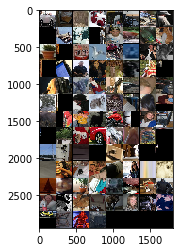

In [112]:
# Sanity check
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)
train_images, train_labels, _ = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

Test images


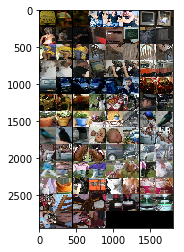

In [113]:
# another Sanity check
test_dataiter = iter(test_loader)
test_images, test_labels, _ = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [114]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [115]:
criterion = nn.CrossEntropyLoss(weight=weights)
# Update if any errors occur
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [116]:
loss_arr = []
def arya_train():
    # Begin
    for epoch in range(num_epochs):
        for i, (image, class_name, _) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(image)
            names = Variable(class_name)
            if(use_gpu):
                images=images.cuda()
                names=names.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, names)
            loss.backward()
            loss_arr.append(loss.data[0])
            optimizer.step()
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [100/206], Loss: 1.0114
Epoch [1/5], Step [200/206], Loss: 0.5535
Epoch [2/5], Step [100/206], Loss: 0.6620
Epoch [2/5], Step [200/206], Loss: 0.3621
Epoch [3/5], Step [100/206], Loss: 0.5340
Epoch [3/5], Step [200/206], Loss: 0.2500
Epoch [4/5], Step [100/206], Loss: 0.2551
Epoch [4/5], Step [200/206], Loss: 0.1470
Epoch [5/5], Step [100/206], Loss: 0.1092
Epoch [5/5], Step [200/206], Loss: 0.2389


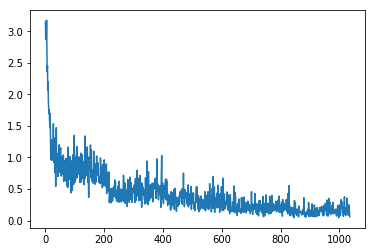

CPU times: user 27min 28s, sys: 51.3 s, total: 28min 20s
Wall time: 9min 49s


In [117]:
%time arya_train()
torch.save(resnet18.state_dict(), 'assignment2_model.pkl')

In [118]:
# resnet18.load_state_dict(torch.load('assignment2_model.pkl'))

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [143]:
# Testing the classification accuracy
def test_classification(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels, name in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(name)
        print(len(name))
        print(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the ' + str(total) + ' test images: %d %%' % (100 * correct / total))

test_classification(resnet18)

('005906.jpg', '005906.jpg', '005906.jpg', '004213.jpg', '004213.jpg', '004213.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '006141.jpg', '007219.jpg', '007219.jpg', '003260.jpg', '003260.jpg', '003260.jpg', '003260.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '004438.jpg', '004438.jpg', '004438.jpg', '004438.jpg', '005152.jpg', '005152.jpg', '009827.jpg', '009827.jpg', '009827.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '004267.jpg', '005871.jpg', '006802.jpg', '006802.jpg', '006802.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '003254.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '003995.jpg', '003995.jpg', '008580.jpg', '007187.jpg', '007187.jpg', '007187.jpg', '007187.jpg', '005513.jpg', '005513.jpg', '002804.jpg', '002804.jpg', '002804.jpg', '0028

('002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002985.jpg', '009223.jpg', '009223.jpg', '009223.jpg', '000348.jpg', '000348.jpg', '000348.jpg', '000348.jpg', '007587.jpg', '007587.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '008941.jpg', '008941.jpg', '008941.jpg', '008941.jpg', '004233.jpg', '004233.jpg', '004233.jpg', '003905.jpg', '008789.jpg', '002621.jpg', '002621.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '0081

('000652.jpg', '000652.jpg', '000652.jpg', '006179.jpg', '006179.jpg', '006179.jpg', '005236.jpg', '005236.jpg', '005236.jpg', '005236.jpg', '006655.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '001704.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '000031.jpg', '002458.jpg', '002458.jpg', '004899.jpg', '004899.jpg', '004899.jpg', '004899.jpg', '000418.jpg', '006329.jpg', '003511.jpg', '008673.jpg', '008673.jpg', '007602.jpg', '007602.jpg', '007602.jpg', '007602.jpg', '001436.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '007747.jpg', '007747.jpg', '007747.jpg', '007747.jpg', '006413.jpg', '006413.jpg', '004567.jpg', '004567.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '003270.jpg', '003270.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '0044

('001129.jpg', '001129.jpg', '005802.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '000434.jpg', '000434.jpg', '006124.jpg', '007837.jpg', '007837.jpg', '001959.jpg', '000354.jpg', '000857.jpg', '001172.jpg', '004633.jpg', '005133.jpg', '005133.jpg', '006669.jpg', '006669.jpg', '006669.jpg', '006664.jpg', '006664.jpg', '007162.jpg', '006254.jpg', '006342.jpg', '003248.jpg', '000568.jpg', '005237.jpg', '005237.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005574.jpg', '005574.jpg', '001614.jpg', '001614.jpg', '001614.jpg', '001614.jpg', '003864.jpg', '0077

('001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '005681.jpg', '009913.jpg', '001930.jpg', '001930.jpg', '001930.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '005337.jpg', '005664.jpg', '005664.jpg', '005664.jpg', '005664.jpg', '008185.jpg', '009858.jpg', '004932.jpg', '004932.jpg', '000102.jpg', '000102.jpg', '004240.jpg', '004240.jpg', '009635.jpg', '009635.jpg', '000019.jpg', '000019.jpg', '006553.jpg', '000290.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '000137.jpg', '000137.jpg', '000137.jpg', '001743.jpg', '001743.jpg', '007539.jpg', '001664.jpg', '006082.jpg', '006082.jpg', '006082.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '006008.jpg', '007612.jpg', '008157.jpg', '008157.jpg', '008157.jpg', '0055

('009265.jpg', '001094.jpg', '003110.jpg', '003110.jpg', '005489.jpg', '005489.jpg', '008547.jpg', '008547.jpg', '008547.jpg', '008547.jpg', '006153.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '003645.jpg', '003645.jpg', '003645.jpg', '003645.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '000263.jpg', '000263.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '001912.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '000206.jpg', '000206.jpg', '000206.jpg', '000206.jpg', '003197.jpg', '003197.jpg', '002756.jpg', '002756.jpg', '007647.jpg', '007647.jpg', '007647.jpg', '003752.jpg', '003752.jpg', '003752.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '0012

('004577.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '004516.jpg', '004516.jpg', '004516.jpg', '004516.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '005497.jpg', '001450.jpg', '001450.jpg', '006842.jpg', '006842.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '008852.jpg', '008852.jpg', '001706.jpg', '001706.jpg', '009844.jpg', '009844.jpg', '009844.jpg', '009844.jpg', '001102.jpg', '001102.jpg', '001102.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '008790.jpg', '008889.jpg', '005058.jpg', '005058.jpg', '004645.jpg', '009012.jpg', '009012.jpg', '009012.jpg', '009012.jpg', '000630.jpg', '000630.jpg', '003863.jpg', '003863.jpg', '006005.jpg', '006005.jpg', '006005.jpg', '000989.jpg', '0004

('005243.jpg', '003128.jpg', '001029.jpg', '008001.jpg', '008001.jpg', '008001.jpg', '008001.jpg', '005383.jpg', '003568.jpg', '003568.jpg', '003816.jpg', '002027.jpg', '002027.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '005432.jpg', '009906.jpg', '009906.jpg', '009906.jpg', '009906.jpg', '009488.jpg', '003455.jpg', '003455.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '007942.jpg', '007942.jpg', '007942.jpg', '007942.jpg', '007464.jpg', '007464.jpg', '001395.jpg', '002413.jpg', '000407.jpg', '000407.jpg', '006689.jpg', '006689.jpg', '0066

('001678.jpg', '001678.jpg', '001678.jpg', '001678.jpg', '007085.jpg', '007085.jpg', '006956.jpg', '006956.jpg', '006956.jpg', '006956.jpg', '006942.jpg', '006609.jpg', '006609.jpg', '000669.jpg', '000669.jpg', '000669.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '008885.jpg', '006003.jpg', '006003.jpg', '004558.jpg', '004558.jpg', '004558.jpg', '004558.jpg', '006692.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '001771.jpg', '001771.jpg', '001771.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '005068.jpg', '005068.jpg', '003437.jpg', '007840.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '000912.jpg', '004687.jpg', '0046

('003073.jpg', '001268.jpg', '001268.jpg', '002720.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '001787.jpg', '004044.jpg', '006801.jpg', '007229.jpg', '006444.jpg', '006444.jpg', '007208.jpg', '007208.jpg', '007208.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '004125.jpg', '004125.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '002078.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005995.jpg', '005995.jpg', '003957.jpg', '003061.jpg', '003061.jpg', '003061.jpg', '004225.jpg', '004225.jpg', '004225.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006099.jpg', '003749.jpg', '0000

('006637.jpg', '006637.jpg', '002972.jpg', '002972.jpg', '001898.jpg', '001898.jpg', '001898.jpg', '001095.jpg', '001095.jpg', '001095.jpg', '001095.jpg', '001848.jpg', '000338.jpg', '000338.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '005115.jpg', '009279.jpg', '009279.jpg', '009279.jpg', '009279.jpg', '001956.jpg', '004822.jpg', '004822.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '003466.jpg', '003466.jpg', '003466.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '008777.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000154.jpg', '000154.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '001492.jpg', '001492.jpg', '001492.jpg', '0014

('009219.jpg', '009219.jpg', '009219.jpg', '001966.jpg', '001966.jpg', '007150.jpg', '007150.jpg', '007150.jpg', '007150.jpg', '002656.jpg', '002656.jpg', '002656.jpg', '002656.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '004138.jpg', '004138.jpg', '005022.jpg', '007490.jpg', '007490.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '002062.jpg', '002062.jpg', '002062.jpg', '008684.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '007036.jpg', '007036.jpg', '007036.jpg', '007036.jpg', '005642.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '003831.jpg', '003831.jpg', '008620.jpg', '007794.jpg', '007792.jpg', '007792.jpg', '007792.jpg', '009466.jpg', '002540.jpg', '002540.jpg', '002540.jpg', '005379.jpg', '005079.jpg', '009019.jpg', '009019.jpg', '007326.jpg', '008198.jpg', '008198.jpg', '0011

('006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '002251.jpg', '009379.jpg', '009379.jpg', '009379.jpg', '004757.jpg', '004757.jpg', '009776.jpg', '009776.jpg', '009776.jpg', '008452.jpg', '008452.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '002562.jpg', '002562.jpg', '002562.jpg', '004151.jpg', '007997.jpg', '007997.jpg', '002601.jpg', '009305.jpg', '004331.jpg', '005024.jpg', '005024.jpg', '007416.jpg', '007416.jpg', '002184.jpg', '002184.jpg', '004751.jpg', '004751.jpg', '001932.jpg', '001932.jpg', '001932.jpg', '005479.jpg', '005479.jpg', '004262.jpg', '007027.jpg', '001446.jpg', '001446.jpg', '0069

('000017.jpg', '000017.jpg', '004925.jpg', '004925.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '009560.jpg', '009321.jpg', '004975.jpg', '009625.jpg', '000831.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005896.jpg', '000629.jpg', '000629.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '006214.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '003569.jpg', '003569.jpg', '003519.jpg', '009890.jpg', '009890.jpg', '001877.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '0006

('005847.jpg', '006543.jpg', '002076.jpg', '004264.jpg', '004448.jpg', '004448.jpg', '004448.jpg', '004715.jpg', '004715.jpg', '004110.jpg', '004110.jpg', '008328.jpg', '003898.jpg', '003898.jpg', '001560.jpg', '008761.jpg', '008761.jpg', '008761.jpg', '008427.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001374.jpg', '007114.jpg', '007114.jpg', '007114.jpg', '006895.jpg', '006895.jpg', '001230.jpg', '004554.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000105.jpg', '000105.jpg', '000105.jpg', '000623.jpg', '000623.jpg', '004021.jpg', '000289.jpg', '004661.jpg', '004661.jpg', '004661.jpg', '004661.jpg', '006585.jpg', '0065

('006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '007531.jpg', '007531.jpg', '007531.jpg', '003908.jpg', '006174.jpg', '006174.jpg', '009714.jpg', '009714.jpg', '002993.jpg', '002993.jpg', '001452.jpg', '001452.jpg', '000501.jpg', '008882.jpg', '008882.jpg', '008075.jpg', '000785.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '000670.jpg', '000670.jpg', '007071.jpg', '005087.jpg', '005087.jpg', '008720.jpg', '008118.jpg', '008118.jpg', '002842.jpg', '002842.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '007666.jpg', '000520.jpg', '009063.jpg', '009063.jpg', '002254.jpg', '002254.jpg', '002254.jpg', '002254.jpg', '007954.jpg', '001660.jpg', '009780.jpg', '009780.jpg', '009780.jpg', '000988.jpg', '001800.jpg', '001800.jpg', '005576.jpg', '0028

('007176.jpg', '007176.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '000180.jpg', '002593.jpg', '007993.jpg', '007993.jpg', '006832.jpg', '005232.jpg', '005232.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '009334.jpg', '001788.jpg', '003727.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '002901.jpg', '002901.jpg', '002901.jpg', '003679.jpg', '003133.jpg', '008422.jpg', '008422.jpg', '008422.jpg', '006131.jpg', '006131.jpg', '006131.jpg', '002709.jpg', '006548.jpg', '0065

('004037.jpg', '007216.jpg', '007216.jpg', '000681.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '007270.jpg', '007270.jpg', '007270.jpg', '003264.jpg', '003264.jpg', '003264.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '000246.jpg', '009107.jpg', '005581.jpg', '005581.jpg', '002757.jpg', '002467.jpg', '002467.jpg', '002467.jpg', '002467.jpg', '000868.jpg', '000868.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '008029.jpg', '008121.jpg', '004809.jpg', '008450.jpg', '002373.jpg', '002373.jpg', '000151.jpg', '000151.jpg', '004619.jpg', '005069.jpg', '005069.jpg', '003371.jpg', '003371.jpg', '003378.jpg', '003378.jpg', '003378.jpg', '003378.jpg', '002956.jpg', '0020

('006351.jpg', '006351.jpg', '006351.jpg', '006846.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '003983.jpg', '003079.jpg', '004538.jpg', '004538.jpg', '008229.jpg', '008229.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001152.jpg', '001152.jpg', '001152.jpg', '001152.jpg', '002366.jpg', '002366.jpg', '001220.jpg', '001220.jpg', '001220.jpg', '001891.jpg', '001891.jpg', '001891.jpg', '004495.jpg', '004495.jpg', '004495.jpg', '004495.jpg', '004667.jpg', '004667.jpg', '004667.jpg', '004667.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '009581.jpg', '009581.jpg', '009581.jpg', '009581.jpg', '009676.jpg', '009676.jpg', '009676.jpg', '006853.jpg', '007823.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '0027

('001627.jpg', '004043.jpg', '004043.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '009011.jpg', '006891.jpg', '006891.jpg', '003796.jpg', '000042.jpg', '000042.jpg', '004003.jpg', '000786.jpg', '000786.jpg', '000786.jpg', '007787.jpg', '000119.jpg', '005971.jpg', '006525.jpg', '001041.jpg', '005890.jpg', '005890.jpg', '001939.jpg', '002007.jpg', '007670.jpg', '007670.jpg', '000759.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '000921.jpg', '000921.jpg', '000921.jpg', '004552.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '005202.jpg', '002071.jpg', '002071.jpg', '002071.jpg', '002071.jpg', '0020

('005706.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '004815.jpg', '004815.jpg', '001500.jpg', '009050.jpg', '009050.jpg', '005382.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '004104.jpg', '004104.jpg', '005851.jpg', '004227.jpg', '004227.jpg', '004227.jpg', '008904.jpg', '003724.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '002167.jpg', '002167.jpg', '002167.jpg', '002167.jpg', '003446.jpg', '003446.jpg', '007686.jpg', '000433.jpg', '000433.jpg', '006297.jpg', '006297.jpg', '006297.jpg', '006297.jpg', '002204.jpg', '002204.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '0007

('001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '008926.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '006670.jpg', '006670.jpg', '006670.jpg', '009186.jpg', '009186.jpg', '000270.jpg', '005803.jpg', '004533.jpg', '002729.jpg', '002729.jpg', '002729.jpg', '000046.jpg', '001068.jpg', '005158.jpg', '003745.jpg', '001030.jpg', '005830.jpg', '006690.jpg', '006690.jpg', '006690.jpg', '006690.jpg', '005621.jpg', '005621.jpg', '002307.jpg', '002307.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '007264.jpg', '007264.jpg', '001804.jpg', '004733.jpg', '000818.jpg', '000818.jpg', '009061.jpg', '000804.jpg', '000804.jpg', '000804.jpg', '001209.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '0021

('004779.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '008518.jpg', '004401.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '007625.jpg', '007625.jpg', '007625.jpg', '007625.jpg', '000674.jpg', '007599.jpg', '007599.jpg', '004206.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '009492.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '006158.jpg', '006158.jpg', '006158.jpg', '000475.jpg', '000475.jpg', '000475.jpg', '000475.jpg', '003188.jpg', '003188.jpg', '003473.jpg', '0034

('006731.jpg', '004919.jpg', '005040.jpg', '005040.jpg', '005040.jpg', '005613.jpg', '005613.jpg', '000022.jpg', '000022.jpg', '001038.jpg', '008849.jpg', '008849.jpg', '009957.jpg', '009957.jpg', '009775.jpg', '003408.jpg', '003408.jpg', '003051.jpg', '006665.jpg', '006665.jpg', '009193.jpg', '009193.jpg', '009193.jpg', '009193.jpg', '009648.jpg', '009082.jpg', '007667.jpg', '006994.jpg', '007434.jpg', '001976.jpg', '001976.jpg', '007454.jpg', '007454.jpg', '008264.jpg', '008264.jpg', '008264.jpg', '008264.jpg', '004961.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '004366.jpg', '004366.jpg', '004366.jpg', '004366.jpg', '008688.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '001110.jpg', '001110.jpg', '000216.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '003125.jpg', '007476.jpg', '007476.jpg', '009562.jpg', '001252.jpg', '007398.jpg', '007398.jpg', '006835.jpg', '0068

('004093.jpg', '004093.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '009716.jpg', '003878.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '005831.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '001828.jpg', '001828.jpg', '001828.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '006512.jpg', '009093.jpg', '003181.jpg', '003181.jpg', '003181.jpg', '003181.jpg', '000799.jpg', '000799.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '000791.jpg', '001591.jpg', '001009.jpg', '001009.jpg', '003019.jpg', '002691.jpg', '002691.jpg', '002691.jpg', '0026

('009294.jpg', '003553.jpg', '003553.jpg', '003553.jpg', '003553.jpg', '002423.jpg', '001824.jpg', '001824.jpg', '001863.jpg', '004908.jpg', '004908.jpg', '009540.jpg', '009540.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '000310.jpg', '000310.jpg', '000310.jpg', '000310.jpg', '006288.jpg', '006288.jpg', '006288.jpg', '006288.jpg', '000422.jpg', '000422.jpg', '000422.jpg', '000422.jpg', '008338.jpg', '008664.jpg', '006798.jpg', '006798.jpg', '004157.jpg', '007011.jpg', '004431.jpg', '004299.jpg', '004299.jpg', '004299.jpg', '004299.jpg', '009867.jpg', '009867.jpg', '009867.jpg', '004743.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '004748.jpg', '004748.jpg', '004748.jpg', '004748.jpg', '001161.jpg', '005498.jpg', '005498.jpg', '005498.jpg', '005413.jpg', '005413.jpg', '005483.jpg', '005483.jpg', '000595.jpg', '000595.jpg', '000595.jpg', '000595.jpg', '0005

('007859.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '007538.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006427.jpg', '006427.jpg', '006427.jpg', '002243.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '005836.jpg', '005836.jpg', '003352.jpg', '003352.jpg', '003352.jpg', '007848.jpg', '000462.jpg', '003213.jpg', '003213.jpg', '003213.jpg', '000020.jpg', '004652.jpg', '002023.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '007642.jpg', '001835.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '005690.jpg', '005594.jpg', '002183.jpg', '002183.jpg', '005249.jpg', '006143.jpg', '0061

('004704.jpg', '004704.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '005602.jpg', '005602.jpg', '002052.jpg', '005834.jpg', '009911.jpg', '000954.jpg', '000954.jpg', '001913.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '003825.jpg', '003825.jpg', '003825.jpg', '003910.jpg', '003910.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '008891.jpg', '008891.jpg', '009049.jpg', '009049.jpg', '009049.jpg', '009049.jpg', '003978.jpg', '003978.jpg', '000049.jpg', '000514.jpg', '008463.jpg', '008463.jpg', '008463.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '000675.jpg', '000675.jpg', '000675.jpg', '007677.jpg', '005106.jpg', '005106.jpg', '008567.jpg', '0062

('003436.jpg', '003436.jpg', '003436.jpg', '002474.jpg', '002474.jpg', '002474.jpg', '008906.jpg', '008906.jpg', '002969.jpg', '003695.jpg', '004210.jpg', '004210.jpg', '009397.jpg', '009397.jpg', '009397.jpg', '005366.jpg', '005366.jpg', '005366.jpg', '005366.jpg', '003906.jpg', '003906.jpg', '001602.jpg', '001602.jpg', '009934.jpg', '007369.jpg', '007369.jpg', '007369.jpg', '007369.jpg', '001570.jpg', '006504.jpg', '006504.jpg', '008285.jpg', '008285.jpg', '000570.jpg', '000570.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '006430.jpg', '004017.jpg', '004017.jpg', '000763.jpg', '000980.jpg', '000121.jpg', '000121.jpg', '004674.jpg', '002112.jpg', '005446.jpg', '005050.jpg', '005050.jpg', '000847.jpg', '000847.jpg', '004306.jpg', '004306.jpg', '007499.jpg', '007499.jpg', '003763.jpg', '007815.jpg', '007815.jpg', '007815.jpg', '009393.jpg', '009393.jpg', '009393.jpg', '0093

('000809.jpg', '000809.jpg', '006947.jpg', '000089.jpg', '000089.jpg', '000089.jpg', '000089.jpg', '003439.jpg', '003439.jpg', '005689.jpg', '004583.jpg', '005285.jpg', '005285.jpg', '008745.jpg', '008745.jpg', '008745.jpg', '008745.jpg', '007322.jpg', '003610.jpg', '007971.jpg', '007971.jpg', '007049.jpg', '007049.jpg', '007049.jpg', '000123.jpg', '009443.jpg', '009443.jpg', '009443.jpg', '006937.jpg', '006937.jpg', '002237.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '002491.jpg', '002491.jpg', '001862.jpg', '001862.jpg', '004669.jpg', '004669.jpg', '003151.jpg', '003151.jpg', '003151.jpg', '008757.jpg', '004513.jpg', '004008.jpg', '004008.jpg', '006851.jpg', '006851.jpg', '004344.jpg', '004344.jpg', '006227.jpg', '005843.jpg', '007331.jpg', '001285.jpg', '001285.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '007051.jpg', '007051.jpg', '002574.jpg', '002574.jpg', '0049

('000398.jpg', '001348.jpg', '001562.jpg', '000387.jpg', '004651.jpg', '007509.jpg', '007509.jpg', '009533.jpg', '009533.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '009701.jpg', '005580.jpg', '007158.jpg', '004829.jpg', '008406.jpg', '008406.jpg', '008406.jpg', '002059.jpg', '003657.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '005132.jpg', '005132.jpg', '004338.jpg', '005016.jpg', '005016.jpg', '000218.jpg', '000218.jpg', '000218.jpg', '003175.jpg', '003175.jpg', '007077.jpg', '007077.jpg', '007077.jpg', '007077.jpg', '006741.jpg', '008854.jpg', '003483.jpg', '003483.jpg', '003483.jpg', '003483.jpg', '0035

('009684.jpg', '003087.jpg', '003087.jpg', '003087.jpg', '001951.jpg', '006822.jpg', '006822.jpg', '009910.jpg', '009910.jpg', '009592.jpg', '009592.jpg', '004061.jpg', '004061.jpg', '006952.jpg', '006978.jpg', '005599.jpg', '005599.jpg', '005599.jpg', '005599.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '009759.jpg', '004641.jpg', '004641.jpg', '004641.jpg', '009203.jpg', '004749.jpg', '004749.jpg', '008268.jpg', '008268.jpg', '008268.jpg', '002609.jpg', '008059.jpg', '008059.jpg', '008059.jpg', '008059.jpg', '007072.jpg', '008173.jpg', '009891.jpg', '002509.jpg', '007517.jpg', '004294.jpg', '004294.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '007606.jpg', '002152.jpg', '004879.jpg', '004879.jpg', '004879.jpg', '006890.jpg', '007655.jpg', '001673.jpg', '001673.jpg', '000542.jpg', '008927.jpg', '0038

('000539.jpg', '005767.jpg', '005767.jpg', '006803.jpg', '006803.jpg', '006803.jpg', '005976.jpg', '005976.jpg', '005976.jpg', '005976.jpg', '005377.jpg', '005377.jpg', '005377.jpg', '005377.jpg', '005675.jpg', '005675.jpg', '005675.jpg', '009277.jpg', '009277.jpg', '005303.jpg', '005303.jpg', '002380.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '005408.jpg', '006298.jpg', '005375.jpg', '005375.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '009639.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '003531.jpg', '003531.jpg', '000386.jpg', '000386.jpg', '000386.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000446.jpg', '000446.jpg', '008031.jpg', '004693.jpg', '004693.jpg', '004693.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '006734.jpg', '001735.jpg', '001735.jpg', '006130.jpg', '0061

('004423.jpg', '004423.jpg', '004423.jpg', '006451.jpg', '006451.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '004345.jpg', '000402.jpg', '000402.jpg', '000402.jpg', '000707.jpg', '000707.jpg', '000707.jpg', '007824.jpg', '002760.jpg', '002760.jpg', '006869.jpg', '003057.jpg', '003057.jpg', '003057.jpg', '008585.jpg', '005607.jpg', '001226.jpg', '008848.jpg', '008848.jpg', '008848.jpg', '008848.jpg', '008735.jpg', '008735.jpg', '000260.jpg', '000260.jpg', '007673.jpg', '007673.jpg', '007673.jpg', '002447.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000716.jpg', '008284.jpg', '008284.jpg', '008284.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002872.jpg', '002872.jpg', '004951.jpg', '004951.jpg', '009609.jpg', '009609.jpg', '001884.jpg', '0018

('005192.jpg', '005192.jpg', '005192.jpg', '008964.jpg', '008964.jpg', '008964.jpg', '004325.jpg', '004252.jpg', '004252.jpg', '004252.jpg', '002749.jpg', '002749.jpg', '005886.jpg', '006355.jpg', '006355.jpg', '006355.jpg', '007263.jpg', '007263.jpg', '007263.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '001520.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '008701.jpg', '008701.jpg', '008701.jpg', '003579.jpg', '003579.jpg', '006424.jpg', '006424.jpg', '008832.jpg', '002537.jpg', '001499.jpg', '001499.jpg', '001499.jpg', '004599.jpg', '004599.jpg', '004599.jpg', '004599.jpg', '007811.jpg', '007811.jpg', '007811.jpg', '009713.jpg', '009713.jpg', '009713.jpg', '009713.jpg', '0061

('007242.jpg', '007242.jpg', '006700.jpg', '007607.jpg', '000573.jpg', '000573.jpg', '009133.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '008939.jpg', '004216.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '001277.jpg', '001613.jpg', '001613.jpg', '009243.jpg', '009386.jpg', '009386.jpg', '003540.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005264.jpg', '005264.jpg', '002077.jpg', '002077.jpg', '005788.jpg', '005788.jpg', '002785.jpg', '009940.jpg', '009940.jpg', '005384.jpg', '005384.jpg', '002984.jpg', '002984.jpg', '002984.jpg', '009912.jpg', '002795.jpg', '002795.jpg', '002795.jpg', '0027

('006546.jpg', '004555.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '002684.jpg', '001418.jpg', '000584.jpg', '000584.jpg', '004650.jpg', '004650.jpg', '004650.jpg', '008447.jpg', '008447.jpg', '008447.jpg', '009907.jpg', '007721.jpg', '007721.jpg', '007721.jpg', '007721.jpg', '005403.jpg', '005654.jpg', '003748.jpg', '003126.jpg', '002610.jpg', '002610.jpg', '002610.jpg', '002610.jpg', '001076.jpg', '001076.jpg', '001076.jpg', '004776.jpg', '008884.jpg', '008884.jpg', '008884.jpg', '008167.jpg', '008167.jpg', '006726.jpg', '008034.jpg', '008034.jpg', '008034.jpg', '008034.jpg', '006400.jpg', '006400.jpg', '006400.jpg', '008822.jpg', '000676.jpg', '005211.jpg', '002702.jpg', '002702.jpg', '002702.jpg', '004632.jpg', '004632.jpg', '002260.jpg', '009359.jpg', '009359.jpg', '004242.jpg', '000160.jpg', '006436.jpg', '000108.jpg', '0001

('004301.jpg', '000461.jpg', '009888.jpg', '001495.jpg', '004063.jpg', '004063.jpg', '004063.jpg', '006485.jpg', '002994.jpg', '002994.jpg', '000358.jpg', '000358.jpg', '008871.jpg', '007671.jpg', '005724.jpg', '005724.jpg', '003875.jpg', '003875.jpg', '003875.jpg', '003875.jpg', '006706.jpg', '006706.jpg', '006706.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '008867.jpg', '008867.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '002208.jpg', '002208.jpg', '008445.jpg', '008445.jpg', '001631.jpg', '001631.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '008275.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '002213.jpg', '002213.jpg', '006537.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '003311.jpg', '003311.jpg', '0033

('002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '000947.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '001303.jpg', '009848.jpg', '009848.jpg', '009848.jpg', '007197.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '005246.jpg', '000559.jpg', '000559.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '007979.jpg', '007979.jpg', '007979.jpg', '008719.jpg', '008719.jpg', '008719.jpg', '002016.jpg', '002016.jpg', '001755.jpg', '001755.jpg', '001166.jpg', '000192.jpg', '000192.jpg', '006617.jpg', '006617.jpg', '008515.jpg', '007507.jpg', '007507.jpg', '007507.jpg', '004439.jpg', '004439.jpg', '004439.jpg', '004439.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '0077

('007147.jpg', '006514.jpg', '006514.jpg', '006675.jpg', '005537.jpg', '005595.jpg', '005595.jpg', '008282.jpg', '008282.jpg', '008282.jpg', '001339.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '007062.jpg', '008256.jpg', '008256.jpg', '003872.jpg', '004942.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '005764.jpg', '007966.jpg', '007966.jpg', '004195.jpg', '004195.jpg', '004195.jpg', '001466.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '003839.jpg', '003839.jpg', '003839.jpg', '002179.jpg', '009422.jpg', '000602.jpg', '0006

('004435.jpg', '004435.jpg', '007056.jpg', '008408.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '007178.jpg', '007178.jpg', '007178.jpg', '008491.jpg', '008491.jpg', '000779.jpg', '006095.jpg', '006095.jpg', '006095.jpg', '003938.jpg', '002352.jpg', '002352.jpg', '002740.jpg', '002740.jpg', '009767.jpg', '009767.jpg', '000604.jpg', '000604.jpg', '001043.jpg', '005736.jpg', '005736.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '005557.jpg', '003658.jpg', '009653.jpg', '009653.jpg', '009653.jpg', '000668.jpg', '001705.jpg', '001705.jpg', '001705.jpg', '009340.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '0075

('003307.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001052.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '004040.jpg', '004040.jpg', '004040.jpg', '006928.jpg', '006967.jpg', '005789.jpg', '005789.jpg', '005789.jpg', '004278.jpg', '000827.jpg', '000827.jpg', '007926.jpg', '009004.jpg', '009004.jpg', '009004.jpg', '009004.jpg', '006565.jpg', '001316.jpg', '003626.jpg', '003626.jpg', '003626.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '001672.jpg', '002571.jpg', '003068.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '001726.jpg', '001726.jpg', '001726.jpg', '001726.jpg', '006946.jpg', '006580.jpg', '006580.jpg', '0065

('004989.jpg', '004989.jpg', '006768.jpg', '006768.jpg', '006768.jpg', '006768.jpg', '005636.jpg', '005636.jpg', '009757.jpg', '003888.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '004782.jpg', '004782.jpg', '004124.jpg', '004124.jpg', '001920.jpg', '001920.jpg', '001920.jpg', '001920.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '007417.jpg', '007417.jpg', '007417.jpg', '005433.jpg', '005433.jpg', '004622.jpg', '004622.jpg', '002417.jpg', '005826.jpg', '006390.jpg', '006390.jpg', '006390.jpg', '006390.jpg', '003981.jpg', '003981.jpg', '009584.jpg', '009584.jpg', '009584.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '000036.jpg', '003312.jpg', '006806.jpg', '006806.jpg', '006806.jpg', '006806.jpg', '007313.jpg', '009016.jpg', '008930.jpg', '007925.jpg', '007925.jpg', '007925.jpg', '0079

('009694.jpg', '009694.jpg', '009694.jpg', '004930.jpg', '004930.jpg', '008414.jpg', '008414.jpg', '002128.jpg', '006694.jpg', '000317.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '007542.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '008614.jpg', '008614.jpg', '008614.jpg', '003530.jpg', '003530.jpg', '008511.jpg', '007015.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '008036.jpg', '006622.jpg', '006622.jpg', '006622.jpg', '007459.jpg', '008712.jpg', '000238.jpg', '000238.jpg', '004164.jpg', '004164.jpg', '004164.jpg', '009728.jpg', '009728.jpg', '004613.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '001315.jpg', '001315.jpg', '008641.jpg', '008641.jpg', '003224.jpg', '003224.jpg', '003224.jpg', '000400.jpg', '0076

('007803.jpg', '004968.jpg', '004968.jpg', '008718.jpg', '008718.jpg', '008718.jpg', '008718.jpg', '002960.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '009118.jpg', '009118.jpg', '003349.jpg', '006474.jpg', '003241.jpg', '006813.jpg', '006813.jpg', '009669.jpg', '002195.jpg', '002195.jpg', '007652.jpg', '007652.jpg', '007652.jpg', '000511.jpg', '004121.jpg', '004121.jpg', '004121.jpg', '003646.jpg', '005119.jpg', '005119.jpg', '006620.jpg', '006620.jpg', '006046.jpg', '006046.jpg', '006046.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '001473.jpg', '001473.jpg', '008189.jpg', '008189.jpg', '002073.jpg', '0037

('007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007343.jpg', '007387.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '005394.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '001713.jpg', '007424.jpg', '000639.jpg', '005833.jpg', '005833.jpg', '006976.jpg', '006976.jpg', '006976.jpg', '009143.jpg', '009143.jpg', '009143.jpg', '008937.jpg', '008937.jpg', '008937.jpg', '008937.jpg', '008451.jpg', '008451.jpg', '008451.jpg', '000097.jpg', '000097.jpg', '0000

('007497.jpg', '007497.jpg', '007617.jpg', '007617.jpg', '004341.jpg', '004903.jpg', '004903.jpg', '004903.jpg', '004903.jpg', '002169.jpg', '000134.jpg', '002915.jpg', '002915.jpg', '002915.jpg', '003788.jpg', '003788.jpg', '007493.jpg', '007493.jpg', '007493.jpg', '007493.jpg', '006011.jpg', '006011.jpg', '006011.jpg', '006011.jpg', '003755.jpg', '003755.jpg', '003755.jpg', '004086.jpg', '004086.jpg', '007463.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '008159.jpg', '008159.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '003944.jpg', '003944.jpg', '003944.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '005145.jpg', '005145.jpg', '008613.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '0034

('008900.jpg', '008900.jpg', '008900.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '002420.jpg', '006222.jpg', '006222.jpg', '009290.jpg', '009290.jpg', '009290.jpg', '009290.jpg', '000132.jpg', '000821.jpg', '009354.jpg', '005984.jpg', '005984.jpg', '005984.jpg', '005984.jpg', '004020.jpg', '004020.jpg', '004020.jpg', '006930.jpg', '005323.jpg', '005323.jpg', '006250.jpg', '002160.jpg', '002160.jpg', '008453.jpg', '008453.jpg', '008453.jpg', '009756.jpg', '009756.jpg', '008532.jpg', '005822.jpg', '005822.jpg', '009103.jpg', '009103.jpg', '009339.jpg', '009339.jpg', '005808.jpg', '005808.jpg', '005808.jpg', '005808.jpg', '009106.jpg', '001778.jpg', '003648.jpg', '003648.jpg', '003648.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '009437.jpg', '009437.jpg', '0094

('007154.jpg', '000393.jpg', '000393.jpg', '006520.jpg', '005573.jpg', '005573.jpg', '007938.jpg', '007938.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '002068.jpg', '006730.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '003165.jpg', '003246.jpg', '008228.jpg', '007407.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '005714.jpg', '005714.jpg', '005714.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '007101.jpg', '004007.jpg', '002031.jpg', '002031.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '009181.jpg', '000911.jpg', '000911.jpg', '000911.jpg', '000911.jpg', '000768.jpg', '000768.jpg', '003799.jpg', '003799.jpg', '008178.jpg', '008178.jpg', '008178.jpg', '009497.jpg', '009497.jpg', '009497.jpg', '009497.jpg', '009960.jpg', '009960.jpg', '004149.jpg', '0041

('006974.jpg', '005270.jpg', '008948.jpg', '008948.jpg', '008948.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001952.jpg', '004778.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '006262.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '006462.jpg', '003064.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '001707.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '009429.jpg', '003348.jpg', '003348.jpg', '003348.jpg', '003348.jpg', '001819.jpg', '001819.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '0007

('006920.jpg', '006920.jpg', '006920.jpg', '006920.jpg', '006920.jpg', '009184.jpg', '009184.jpg', '009184.jpg', '006633.jpg', '006633.jpg', '006633.jpg', '006633.jpg', '007078.jpg', '007078.jpg', '007078.jpg', '007078.jpg', '005671.jpg', '005916.jpg', '005916.jpg', '005916.jpg', '008727.jpg', '004897.jpg', '004897.jpg', '004897.jpg', '000703.jpg', '007086.jpg', '006943.jpg', '006943.jpg', '006943.jpg', '006943.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '006137.jpg', '006137.jpg', '006137.jpg', '000599.jpg', '000599.jpg', '002469.jpg', '002469.jpg', '009179.jpg', '009179.jpg', '009179.jpg', '009179.jpg', '004297.jpg', '004297.jpg', '005559.jpg', '004480.jpg', '004480.jpg', '003668.jpg', '008851.jpg', '003967.jpg', '003967.jpg', '003967.jpg', '003967.jpg', '0039

('008596.jpg', '008596.jpg', '007375.jpg', '007375.jpg', '007375.jpg', '007375.jpg', '003190.jpg', '003190.jpg', '003190.jpg', '003190.jpg', '004602.jpg', '001938.jpg', '002592.jpg', '009302.jpg', '009302.jpg', '000034.jpg', '000034.jpg', '005494.jpg', '005494.jpg', '004228.jpg', '004228.jpg', '004228.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '000645.jpg', '000645.jpg', '000161.jpg', '000161.jpg', '002885.jpg', '002885.jpg', '002885.jpg', '002885.jpg', '003522.jpg', '007724.jpg', '001084.jpg', '001084.jpg', '008597.jpg', '008597.jpg', '009823.jpg', '006410.jpg', '006410.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006744.jpg', '006744.jpg', '009381.jpg', '009381.jpg', '004087.jpg', '004087.jpg', '008194.jpg', '008779.jpg', '002170.jpg', '002170.jpg', '002170.jpg', '002170.jpg', '003474.jpg', '008243.jpg', '005247.jpg', '008660.jpg', '009258.jpg', '0092

('005191.jpg', '005191.jpg', '005191.jpg', '006632.jpg', '006632.jpg', '002977.jpg', '002977.jpg', '004672.jpg', '004672.jpg', '001605.jpg', '001605.jpg', '001605.jpg', '001605.jpg', '009373.jpg', '009373.jpg', '006319.jpg', '006319.jpg', '005902.jpg', '005902.jpg', '005902.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '005952.jpg', '005952.jpg', '002995.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '007448.jpg', '007448.jpg', '001910.jpg', '008657.jpg', '002975.jpg', '002975.jpg', '006175.jpg', '007944.jpg', '007944.jpg', '007944.jpg', '001962.jpg', '001962.jpg', '007719.jpg', '007719.jpg', '007719.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '003370.jpg', '005828.jpg', '009789.jpg', '0097

('005101.jpg', '005101.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '001000.jpg', '003135.jpg', '002866.jpg', '002866.jpg', '002866.jpg', '002866.jpg', '003301.jpg', '003301.jpg', '003301.jpg', '003301.jpg', '001867.jpg', '001867.jpg', '001867.jpg', '001867.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003360.jpg', '003360.jpg', '003360.jpg', '001763.jpg', '001763.jpg', '001763.jpg', '001763.jpg', '002712.jpg', '002712.jpg', '000028.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '007914.jpg', '000879.jpg', '000879.jpg', '006058.jpg', '003142.jpg', '005470.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '0033

('009188.jpg', '001576.jpg', '004777.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '005011.jpg', '001078.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '006247.jpg', '007358.jpg', '007358.jpg', '007358.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '008952.jpg', '008952.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '003536.jpg', '003536.jpg', '001648.jpg', '001648.jpg', '001648.jpg', '001648.jpg', '005208.jpg', '007595.jpg', '000357.jpg', '002728.jpg', '002728.jpg', '0027

('008786.jpg', '008786.jpg', '008786.jpg', '008786.jpg', '006020.jpg', '006020.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '005550.jpg', '005550.jpg', '000210.jpg', '000210.jpg', '000210.jpg', '000210.jpg', '000414.jpg', '000414.jpg', '000414.jpg', '003624.jpg', '000890.jpg', '000890.jpg', '000890.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '005977.jpg', '005977.jpg', '002876.jpg', '006708.jpg', '006708.jpg', '006708.jpg', '009371.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '001463.jpg', '001463.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '003442.jpg', '003442.jpg', '003442.jpg', '000009.jpg', '000009.jpg', '000009.jpg', '0000

('000663.jpg', '000663.jpg', '000663.jpg', '000663.jpg', '000968.jpg', '003184.jpg', '003184.jpg', '003996.jpg', '003996.jpg', '002797.jpg', '002797.jpg', '000375.jpg', '001808.jpg', '001808.jpg', '001808.jpg', '001808.jpg', '002900.jpg', '008391.jpg', '008391.jpg', '008391.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '009215.jpg', '009215.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '000957.jpg', '000957.jpg', '001485.jpg', '001485.jpg', '001485.jpg', '003104.jpg', '009098.jpg', '009098.jpg', '003937.jpg', '008165.jpg', '008165.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '000991.jpg', '000991.jpg', '004964.jpg', '004964.jpg', '004964.jpg', '006732.jpg', '006732.jpg', '006732.jpg', '005592.jpg', '000342.jpg', '000342.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '0071

('009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '001111.jpg', '001111.jpg', '001111.jpg', '001111.jpg', '006929.jpg', '003172.jpg', '003172.jpg', '003172.jpg', '003172.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '006870.jpg', '005159.jpg', '005159.jpg', '005159.jpg', '000898.jpg', '000898.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '008707.jpg', '008707.jpg', '008707.jpg', '007426.jpg', '007426.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '002869.jpg', '003623.jpg', '001858.jpg', '005838.jpg', '000774.jpg', '003776.jpg', '003776.jpg', '003776.jpg', '004970.jpg', '003588.jpg', '003588.jpg', '007232.jpg', '007232.jpg', '0093

('007294.jpg', '007130.jpg', '007130.jpg', '007130.jpg', '007662.jpg', '008625.jpg', '008625.jpg', '008625.jpg', '007155.jpg', '000575.jpg', '000575.jpg', '000575.jpg', '009544.jpg', '002770.jpg', '000534.jpg', '008888.jpg', '008888.jpg', '008888.jpg', '009035.jpg', '003951.jpg', '003951.jpg', '006261.jpg', '006261.jpg', '006261.jpg', '003397.jpg', '003397.jpg', '003806.jpg', '003806.jpg', '005792.jpg', '005792.jpg', '001411.jpg', '001411.jpg', '001411.jpg', '001411.jpg', '001797.jpg', '001797.jpg', '001797.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '002230.jpg', '002230.jpg', '002230.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '006957.jpg', '006957.jpg', '006957.jpg', '006957.jpg', '004595.jpg', '004595.jpg', '005416.jpg', '006509.jpg', '006509.jpg', '006509.jpg', '009158.jpg', '005330.jpg', '0068

('005908.jpg', '000250.jpg', '000250.jpg', '006207.jpg', '006207.jpg', '000305.jpg', '000305.jpg', '007419.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '004596.jpg', '006816.jpg', '006816.jpg', '009024.jpg', '009024.jpg', '007765.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '003395.jpg', '003395.jpg', '003395.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '007483.jpg', '001243.jpg', '000330.jpg', '000330.jpg', '004767.jpg', '001003.jpg', '008713.jpg', '004385.jpg', '000970.jpg', '000970.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006820.jpg', '007119.jpg', '002341.jpg', '002341.jpg', '002341.jpg', '002341.jpg', '002810.jpg', '000312.jpg', '007756.jpg', '007756.jpg', '007756.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '002485.jpg', '002485.jpg', '002946.jpg', '0046

('006388.jpg', '002459.jpg', '001088.jpg', '006209.jpg', '006209.jpg', '005903.jpg', '005903.jpg', '005903.jpg', '007628.jpg', '007628.jpg', '007628.jpg', '001055.jpg', '001055.jpg', '007257.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '004799.jpg', '006898.jpg', '006898.jpg', '000421.jpg', '000421.jpg', '006985.jpg', '004638.jpg', '008094.jpg', '008094.jpg', '008094.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '000444.jpg', '000444.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '008296.jpg', '008296.jpg', '0082

('002089.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '001734.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '003322.jpg', '003322.jpg', '005051.jpg', '005051.jpg', '006627.jpg', '006627.jpg', '006627.jpg', '006627.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005746.jpg', '005746.jpg', '005746.jpg', '005746.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '002080.jpg', '008249.jpg', '008249.jpg', '008249.jpg', '002468.jpg', '002468.jpg', '009256.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '004096.jpg', '002460.jpg', '002460.jpg', '008021.jpg', '002860.jpg', '002860.jpg', '002860.jpg', '007991.jpg', '0087

In [194]:
def theon_sliding_window(img,resnet18):
    W,H = img.size
#     print(W,H)
    windows = [224]
    arat = [1]
    stride = 10
    thresh = 0
    boxes = []
    lab = []
    composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)), transforms.ToTensor()])
    for win in windows:
        for rat in arat:
            wid = int(win*rat)
            hei = int(win)
            for x,y in np.ndindex((int((W-wid)/stride),int((H-hei)/stride))):
                imgc = img.crop((x * stride, y * stride, x * stride + wid, y * stride + hei)).convert('RGB')
                imgt = composed_transform(imgc)
                imshow(imgt)
                images = Variable(imgt)
                images = images.unsqueeze(0)
                if (use_gpu):
                    images = images.cuda()
                output = resnet18(images)
#                 maxval,label = torch.topk(output.data,1)
#                 if(maxval[0][0]>thresh and label[0][0]!=0):
#                     print(maxval[0][0],label[0][0])
#                     boxes.append([x*stride,y*stride,x*stride+wid,y*stride+hei])
#                     lab.append(label[0][0])
                maxval, prediction = torch.max(output.data, 1)
                maxval, prediction = maxval.cpu().numpy(), prediction.cpu().numpy()
                if(maxval>thresh and prediction != 0):
                    print(maxval, prediction)
                    boxes.append([x*stride,y*stride,x*stride+wid,y*stride+hei])
                    lab.append(prediction)
    return (boxes,lab)

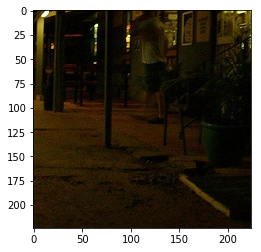

In [195]:
img = Image.open('/home/eeshangd/vision_env/LELImproved/dataset/test/VOCdevkit/VOC2007/JPEGImages/005906.jpg')
boxes, lablist = theon_sliding_window(img,resnet18)
draw = ImageDraw.Draw(img)
for box in boxes:
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), fill="black")
img.show()

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [56]:
def aegon_targaryen_non_maximum_supression(boxes,lablist,threshold = 0.3):
    if len(boxes) == 0:
        return []

    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return (boxes[pick],lablist[pick])

Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [57]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
#     for images, labels, orig_images in test_loader:
    root_dir='/home/eeshangd/vision_env/LELImproved/dataset/'
    rdir = root_dir + 'test/VOCdevkit/VOC2007/'
    anotdir = rdir + 'Annotations/'
    imdir   = rdir + 'JPEGImages/'
    mapscore = []
    for filepath in glob.glob(anotdir+'*.xml'):
        tree = ET.parse(filepath)
        root = tree.getroot()
        filename = root.find('filename').text
        bboxarr = [[] for x in range(20)]
        #Loop on every object of the loop
        for objects in root.findall('object'):
            class_name = objects.find('name').text
            box_position = [int(objects.find('bndbox').find('xmin').text), \
                            int(objects.find('bndbox').find('ymin').text), \
                            int(objects.find('bndbox').find('xmax').text), \
                            int(objects.find('bndbox').find('ymax').text)]
            bboxarr[classes.index(class_name)-1].append(box_position)
        o_img = Image.open(imdir+filename)
        boxes,lablist = theon_sliding_window(o_img, resnet18)
        print(len(boxes))
        boxes,lablist = aegon_targaryen_non_maximum_supression(boxes,lablist)
        true_p = [0]*20
        false_p = [0]*20
        for ind in range(len(boxes)):
            clist = bboxarr[lablist[ind]-1]
            boxt = boxes[ind]
            none = True
            for boxB in clist:
                if bb_intersection_over_union(boxt, boxB)>0.5:
                    true_p[lablist[ind]-1]+=1
                    clist.remove(boxB)
                    none = False
                    break
            if none:
                false_p[lablist[ind]-1]+=1
        true_p  = np.array(true_p,dtype=float)
        false_p = np.array(false_p,dtype=float)
        mapscore.append(np.mean(true_p/(true_p+false_p)))
    print("mAP score is %d",np.mean(np.array(mapscore)))
                

In [58]:
%time daenerys_test(resnet18)

0


ValueError: need more than 0 values to unpack

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [7]:
print ("The night has ended. Winter is finally over!")

The night has ended. Winter is finally over!
